In [1]:
# =================== CELDA 0 — CONFIG & HELPERS (VERSIÓN FINAL) ===================
import pathlib, os, sys, random, warnings
from pathlib import Path
from datetime import datetime
import numpy as np, pandas as pd
import matplotlib as mpl, matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

# --- REPRODUCIBILIDAD ---
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

# --- ESTILO "NATURE-READY" ---
sns.set_theme(style="white", context="paper")
mpl.rcParams.update({
    "pdf.fonttype": 42, "ps.fonttype": 42,       # Texto editable en Illustrator
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 9, "axes.titlesize": 10, "axes.labelsize": 9,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8,
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.linewidth": 0.8, "xtick.major.width": 0.8, "ytick.major.width": 0.8,
    "xtick.direction": "out", "ytick.direction": "out",
    "figure.dpi": 300, "savefig.pad_inches": 0.02,
})

# --- RUTAS Y PARÁMETROS GLOBALES ---
if 'N_FOLDS' not in globals():      N_FOLDS = 5
if 'BASE_RUN_DIR' not in globals(): BASE_RUN_DIR = Path('./resultados_13_paper')
if 'CLF' not in globals():          CLF = 'mlp'
if 'SUFFIX' not in globals():       SUFFIX = '_integrated_gradients_top50'
if 'CHANNELS_TO_USE' not in globals(): CHANNELS_TO_USE = [1, 2, 5]

FIG_DIR = Path('./Figures_Nature'); FIG_DIR.mkdir(exist_ok=True, parents=True)
TBL_DIR = Path('./Tables_Nature');  TBL_DIR.mkdir(exist_ok=True, parents=True)

if 'GLOBAL_TENSOR_PATH' not in globals():
    GLOBAL_TENSOR_PATH = '/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
if 'METADATA_PATH' not in globals():
    METADATA_PATH      = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv'

# --- FUNCIÓN DE GUARDADO "PAPER-READY" ---
def savefig_nature(fig, path_no_ext, dpi_png=600, transparent_png=False, extra_meta=None):
    """Guarda .pdf y .png (alta resolución) con bbox tight y metadatos."""
    p = pathlib.Path(path_no_ext)
    p.parent.mkdir(parents=True, exist_ok=True)
    meta = {
        "Creator": "Matplotlib", "Title": p.name, "CreationDate": datetime.now(),
    }
    if extra_meta: meta.update(extra_meta)
    
    fig.savefig(p.with_suffix(".pdf"), metadata=meta)
    fig.savefig(p.with_suffix(".png"), dpi=dpi_png, transparent=transparent_png,
                metadata={"Creator": "Matplotlib"})

print("✅ Config cargada: N_FOLDS=", N_FOLDS, "| CLF=", CLF, "| SUFFIX=", SUFFIX)

✅ Config cargada: N_FOLDS= 5 | CLF= mlp | SUFFIX= _integrated_gradients_top50


### Atribución en el espacio latente (SHAP)

Sea $x$ el conectoma multicanal y $f:\mathbb{R}^d\to[0,1]$ el clasificador que recibe $\mu(x)\in\mathbb{R}^d$ (medias latentes del VAE) y metadatos $m$.
Para cada latente $\ell$, el valor SHAP $ \phi_\ell(x) $ aproxima la contribución marginal esperada de $\mu_\ell(x)$ a $f$.
Definimos un peso discriminativo por latente como diferencia de medias entre grupos:

$$
w_\ell \;=\; \mathbb{E}[\phi_\ell \mid AD]\;-\;\mathbb{E}[\phi_\ell \mid CN],
\qquad \text{y normalizamos } \; \tilde{w}_\ell = \frac{w_\ell}{\sum_k |w_k|}.
$$

Estos $\tilde{w}$ inducen una función escalar de saliencia
$$
F(x)\;=\;\sum_{\ell=1}^d \tilde{w}_\ell\, \mu_\ell(x) \;=\; \tilde{w}^{\top}\,\mu(x),
$$
que resume “hacia AD” (signo +) o “hacia CN” (−) en el espacio latente.


In [2]:
# ===================================================================
# CELDA 1: CANALES (coherentes con tu CLI: --channels_to_use 1 2 5)
# ===================================================================
CHANNEL_CATALOG = {
    0: "Pearson_OMST_GCE_Signed_Weighted",
    1: "Pearson_Full_FisherZ_Signed",
    2: "MI_kNN_Symmetric",
    3: "dFC_AbsDiffMean",
    4: "dFC_StdDev",
    5: "DistanceCorr",
    6: "Granger_F_lag1",
}
CHANNELS_TO_USE = [1, 2, 5]
sel_names = [CHANNEL_CATALOG[c] for c in CHANNELS_TO_USE]
print("[Canales]", CHANNELS_TO_USE, "=>", sel_names)

# Para el paper: C debe ser 3 (no 4) y nombres como arriba.


[Canales] [1, 2, 5] => ['Pearson_Full_FisherZ_Signed', 'MI_kNN_Symmetric', 'DistanceCorr']


In [3]:
# ===================================================================
# CELDA 2 (UNIFICADA): CARGA DE RANKINGS Y CREACIÓN DE ID CANÓNICO
# ===================================================================
all_folds = []
for i in range(1, N_FOLDS + 1):
    path = BASE_RUN_DIR / f"fold_{i}/interpretability_{CLF}/ranking_conexiones_ANOTADO{SUFFIX}.csv"
    if not path.exists():
        print(f"⚠️ Falta fold {i}: {path}")
        continue
    df_i = pd.read_csv(path)
    
    # --- Lógica de la Celda 2bis integrada aquí ---
    # Crear un ID canónico (tupla ordenada) para cada conexión
    df_i["connection_id"] = [tuple(sorted(x)) for x in zip(df_i["src_AAL3_Name"], df_i["dst_AAL3_Name"])]
    df_i["fold"] = i
    all_folds.append(df_i)

if not all_folds:
    raise FileNotFoundError("No se encontró ningún ranking de conexiones.")

# Concatenar todos los dataframes en uno solo
df_full = pd.concat(all_folds, ignore_index=True)

# --- Verificación de la Celda 2bis integrada aquí ---
assert "connection_id" in df_full.columns
assert df_full["connection_id"].map(type).eq(tuple).all(), "La columna 'connection_id' DEBE ser una tupla."

print(f"✅ df_full cargado y preprocesado con {df_full['fold'].nunique()} folds y {len(df_full)} filas.")
print(f"   - Cada conexión tiene un 'connection_id' canónico.")

✅ df_full cargado y preprocesado con 5 folds y 42575 filas.
   - Cada conexión tiene un 'connection_id' canónico.


In [4]:
# ===================================================================
# CELDA 3 (UNIFICADA): ANÁLISIS DE ESTABILIDAD Y LATERALIDAD (CORREGIDA)
# ===================================================================
from collections import Counter
from scipy.stats import t

# --- 1. ESTABILIDAD: Cálculo de π (frecuencia) y τ (consistencia de signo) ---
TOP_K_STABILITY = 200
n_folds = df_full['fold'].nunique()

top_sets = df_full[df_full["Rank"] <= TOP_K_STABILITY].groupby("fold")["connection_id"].apply(set)
pi = pd.Series(Counter(e for s in top_sets for e in s)).div(n_folds)
pi.name = "pi"

# Use 'Saliency_Signed' which exists in your CSV files
sign = np.sign(df_full.set_index(["connection_id", "fold"])["Saliency_Signed"]).unstack() # <-- CORREGIDO
tau = sign.mean(axis=1).abs()
tau.name = "tau"

df_stability = pd.concat([pi, tau], axis=1).fillna({"pi": 0.0})
df_stability["Signed"] = df_stability["pi"] * df_stability["tau"]

# --- 2. CONSENSUS SET: Filtrado por umbrales estrictos ---
CONS_PI, CONS_TAU = 0.6, 0.6
consensus_set = df_stability.query("pi >= @CONS_PI and tau >= @CONS_TAU").sort_values("Signed", ascending=False)
print(f"🔎 Consensus Set: {len(consensus_set)} aristas (π ≥ {CONS_PI}, τ ≥ {CONS_TAU})")
display(consensus_set.head(10))


# --- 3. LATERALIDAD: Preparación de datos para la figura ---
midline_tokens = {'VER','VPL','PAG','NCR','tVPL','VER7','VER8','VER9'}

def hemi_of(roi: str) -> str:
    if not isinstance(roi, str): return 'U'
    if roi.endswith('R'): return 'R'
    if roi.endswith('L'): return 'L'
    base = ''.join([c for c in roi if not c.isdigit()])
    return 'M' if any(t in base for t in midline_tokens) else 'U'

df_full['hemi_src'] = df_full['src_AAL3_Name'].map(hemi_of)
df_full['hemi_dst'] = df_full['dst_AAL3_Name'].map(hemi_of)
df_lat_clean = df_full.query("hemi_src in ['L','R'] and hemi_dst in ['L','R']").copy()
print(f"\n✅ Conexiones de línea media filtradas para análisis de lateralidad: {len(df_lat_clean)} restantes.")

def p_rr_by_fold(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    out = []
    for f, g in top.groupby("fold", observed=True):
        rr = (g["hemi_src"] == "R").sum()
        ll = (g["hemi_src"] == "L").sum()
        n  = rr + ll
        out.append({"fold": int(f), "TopK": K, "p_RR": (rr / n) if n > 0 else np.nan})
    return pd.DataFrame(out)

df_lat_plot = pd.concat(
    [p_rr_by_fold(df_lat_clean, K) for K in (50, 100, 200)], 
    ignore_index=True
)
print("✅ DataFrame 'df_lat_plot' para figura de lateralidad creado exitosamente.")

# --- 4. PREPARAR DATOS PARA CELDAS DE VISUALIZACIÓN POSTERIORES ---
# Recrea el diccionario 'all_fold_edges' para la figura "small-multiples"
all_fold_edges = {fold: data.set_index('connection_id') for fold, data in df_full.groupby('fold')}

# Recrea 'df_all_Signeds' para la figura "dotplot"
df_all_scores = df_full.pivot_table(
    index='connection_id', 
    columns='fold', 
    values='Saliency_Signed'  # <-- CORREGIDO
).rename(columns=lambda c: f'saliency_fold_{c}')

print("✅ Variables auxiliares 'all_fold_edges' y 'df_all_scores' creadas para las figuras.")

🔎 Consensus Set: 9 aristas (π ≥ 0.6, τ ≥ 0.6)


,,pi,tau,Signed
CER9R,OFCLATR,0.6,1.0,0.60
GRR,OFCLATR,0.6,0.6,0.36
GRL,OFCLATR,0.6,0.6,0.36
OFCLATR,PALLR,0.6,0.6,0.36
P1L,VER6,0.6,0.6,0.36
FMR,OFCLATR,0.6,0.6,0.36
AMYGDL,VER9,0.6,0.6,0.36
CER9L,OFCLATR,0.6,0.6,0.36
F3TR,OFCLATR,0.6,0.6,0.36



✅ Conexiones de línea media filtradas para análisis de lateralidad: 38130 restantes.
✅ DataFrame 'df_lat_plot' para figura de lateralidad creado exitosamente.
✅ Variables auxiliares 'all_fold_edges' y 'df_all_scores' creadas para las figuras.


In [5]:
# =================== EXPORTAR TABLA DE CONSENSO A LaTeX ===================
from pathlib import Path

# 1) Columnas de red (prefiere "Refined" si existe)
net_src_col = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
net_dst_col = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'

# 2) Mapeo ROI -> red (robusto a que el ROI aparezca como src o dst)
roi2net = {}

for _, r in df_full[['src_AAL3_Name', net_src_col]].dropna().drop_duplicates().iterrows():
    roi2net[r['src_AAL3_Name']] = r[net_src_col]

for _, r in df_full[['dst_AAL3_Name', net_dst_col]].dropna().drop_duplicates().iterrows():
    roi2net.setdefault(r['dst_AAL3_Name'], r[net_dst_col])

# 3) Construir filas LaTeX (ordenadas por score = π×τ, descendente)
def _tex_escape(s: str) -> str:
    return str(s).replace('_', r'\_')

rows = []
cons_sorted = consensus_set.sort_values('Signed', ascending=False)
assert len(cons_sorted) == 9, f"Esperaba 17 aristas; obtuve {len(cons_sorted)}."

for (a, b), r in cons_sorted.iterrows():
    net_a = roi2net.get(a, '')
    net_b = roi2net.get(b, '')
    fila = (
        f"{_tex_escape(a)} & {_tex_escape(b)} & "
        f"{_tex_escape(net_a)}—{_tex_escape(net_b)} & "
        f"{r['pi']:.2f} & {r['tau']:.2f} \\\\"
    )
    rows.append(fila)

# 4) Guardar el .tex con solo las filas (para \input{} en LaTeX)
Path('Tables_Nature').mkdir(parents=True, exist_ok=True)
out_path = Path('Tables_Nature/consensus_edges.tex')
out_path.write_text("\n".join(rows), encoding='utf-8')

print(f"✅ Escribí {len(rows)} filas en:", out_path.resolve())
print("\nVista previa (primeras 5 filas):\n", "\n".join(rows[:5]))


✅ Escribí 9 filas en: /home/diego/Escritorio/limpio/Tables_Nature/consensus_edges.tex

Vista previa (primeras 5 filas):
 CER9R & OFCLATR & Cerebellum—DefaultMode\_VentralMedial & 0.60 & 1.00 \\
GRR & OFCLATR & Limbic\_B\_OFC—DefaultMode\_VentralMedial & 0.60 & 0.60 \\
GRL & OFCLATR & Limbic\_B\_OFC—DefaultMode\_VentralMedial & 0.60 & 0.60 \\
OFCLATR & PALLR & DefaultMode\_VentralMedial—Basal\_Ganglia & 0.60 & 0.60 \\
P1L & VER6 & DorsalAttention\_A—Visual\_Peripheral & 0.60 & 0.60 \\


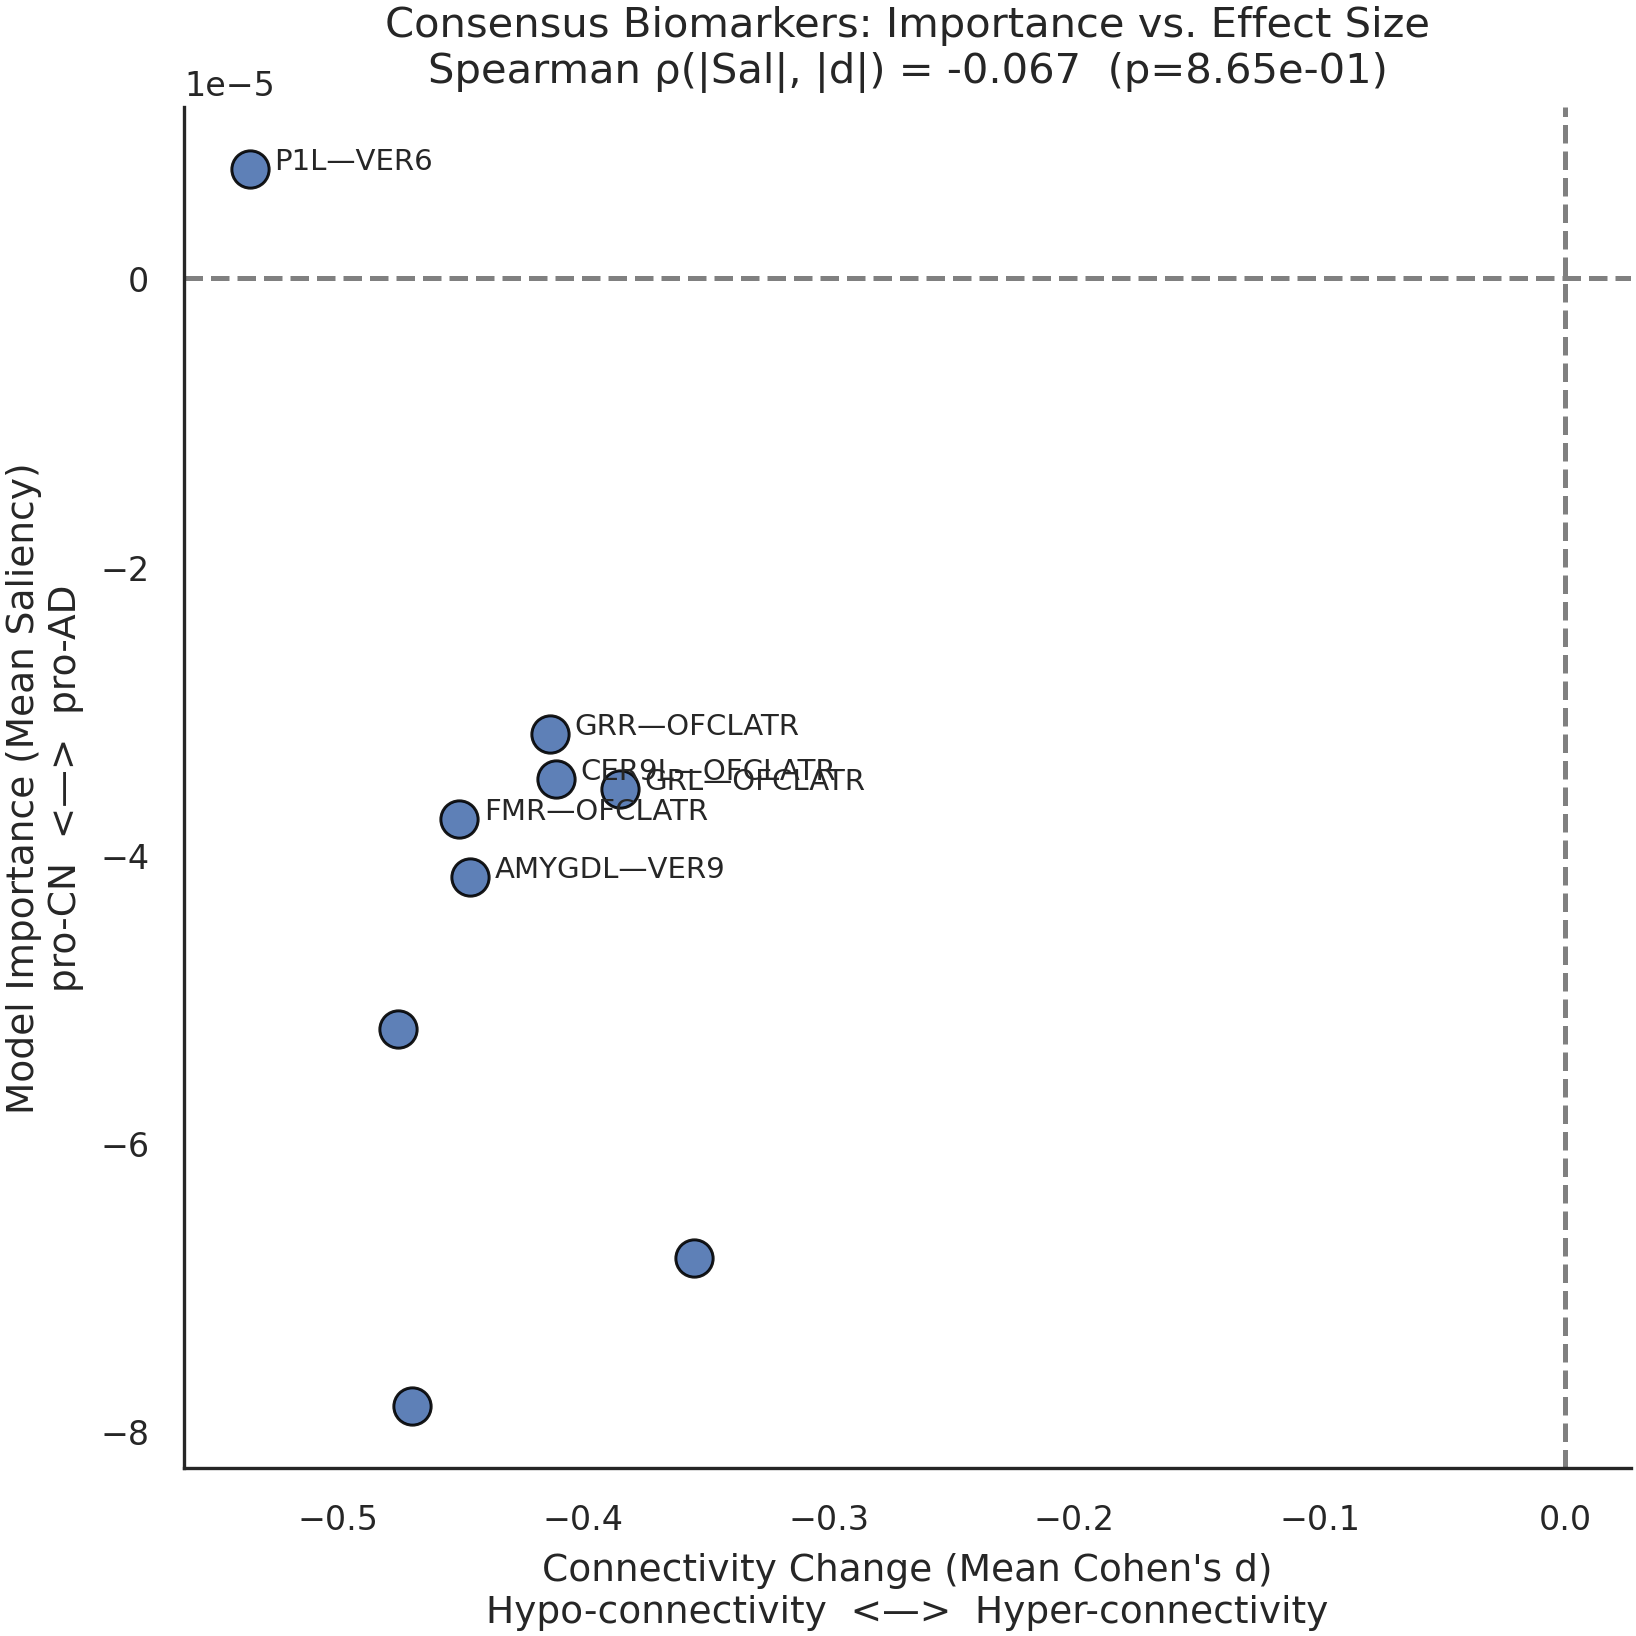

✅ mean_cohen_d calculado en test por fold y promediado entre folds.
   - Figura de dispersión guardada en 'Figures_Nature/fig_SI_quadrant_plot.pdf/png'.
   - DataFrame 'df_consensus_analysis' contiene los datos para análisis adicional.
                  mean_saliency  mean_cohen_d       conn_str
(AMYGDL, VER9)        -0.000042     -0.446150    AMYGDL—VER9
(CER9L, OFCLATR)      -0.000035     -0.410894  CER9L—OFCLATR
(CER9R, OFCLATR)      -0.000078     -0.469845  CER9R—OFCLATR
(F3TR, OFCLATR)       -0.000052     -0.475171   F3TR—OFCLATR
(FMR, OFCLATR)        -0.000038     -0.450404    FMR—OFCLATR
(GRL, OFCLATR)        -0.000035     -0.385069    GRL—OFCLATR
(GRR, OFCLATR)        -0.000032     -0.413431    GRR—OFCLATR
(OFCLATR, PALLR)      -0.000068     -0.354755  OFCLATR—PALLR
(P1L, VER6)            0.000008     -0.535734       P1L—VER6
-0.06666666666666667 0.8646897846262037


In [6]:
# ===================================================================
# CELDA REEMPLAZO: Saliencia (media) vs. Cambio de Conectividad (Cohen's d real)
# ===================================================================
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import spearmanr

# --- Utilidad estable para d de Cohen (AD - CN) ---
def cohen_d(ad, cn, eps=1e-9):
    ad, cn = np.asarray(ad), np.asarray(cn)
    nx, ny = ad.size, cn.size
    if nx < 2 or ny < 2:
        return np.nan
    dof = nx + ny - 2
    s_ad = np.var(ad, ddof=1)
    s_cn = np.var(cn, ddof=1)
    pooled = np.sqrt(((nx - 1) * s_ad + (ny - 1) * s_cn) / max(dof, 1))
    if pooled < eps:
        return 0.0
    return (np.mean(ad) - np.mean(cn)) / pooled

# --- Carga de tensor y metadatos (usa tus rutas ya definidas) ---
npz = np.load(GLOBAL_TENSOR_PATH)
# Filtrar a canales seleccionados y mantener orden de sujetos del NPZ
tensor_all = npz["global_tensor_data"][:, CHANNELS_TO_USE, :, :]  # [n_subj, n_chan_sel, R, R]
subj_all_ids = pd.Series(npz["subject_ids"].astype(str), name="SubjectID")

meta = pd.read_csv(METADATA_PATH, usecols=["SubjectID", "ResearchGroup_Mapped"])
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

# DataFrame maestro alineado al NPZ
idx_df = pd.DataFrame({"SubjectID": subj_all_ids, "tensor_idx": np.arange(len(subj_all_ids))})
merged = idx_df.merge(meta, on="SubjectID", how="left")
cnad_df = merged[merged["ResearchGroup_Mapped"].isin(["CN", "AD"])].reset_index(drop=True)

# --- Conjunto de conexiones a evaluar y su (idx_i, idx_j) canónico ---
if not {"idx_i", "idx_j"}.issubset(df_full.columns):
    raise KeyError("df_full debe contener columnas 'idx_i' e 'idx_j' para mapear ROIs.")

conn_map = (
    df_full[["connection_id", "idx_i", "idx_j"]]
    .drop_duplicates("connection_id")
    .set_index("connection_id")
    .astype(int)
)

# --- d de Cohen por fold en TEST y promedio entre folds ---
N_FOLDS_FOUND = df_full["fold"].nunique()
cohen_per_fold = []

for f in range(1, N_FOLDS_FOUND + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    if not test_idx_path.exists():
        print(f"⚠️ Falta test_indices en fold {f}: {test_idx_path}. Se omite este fold.")
        continue

    test_indices_in_cnad = np.load(test_idx_path)  # índices sobre cnad_df
    test_df = cnad_df.iloc[test_indices_in_cnad]

    ad_idx = test_df[test_df["ResearchGroup_Mapped"] == "AD"]["tensor_idx"].to_numpy()
    cn_idx = test_df[test_df["ResearchGroup_Mapped"] == "CN"]["tensor_idx"].to_numpy()

    if len(ad_idx) < 2 or len(cn_idx) < 2:
        print(f"⚠️ Muy pocos sujetos en test para fold {f}. Se omite.")
        continue

    rows = []
    for conn, (i, j) in conn_map.iterrows():
        # valor de conectividad por sujeto (promedio sobre canales seleccionados)
        # shape: [n_subj]
        vals_all = tensor_all[:, :, i, j].mean(axis=1)
        dval = cohen_d(vals_all[ad_idx], vals_all[cn_idx])
        rows.append((conn, dval))

    df_fold_d = pd.DataFrame(rows, columns=["connection_id", f"cohen_d_fold_{f}"]).set_index("connection_id")
    cohen_per_fold.append(df_fold_d)

if not cohen_per_fold:
    raise RuntimeError("No se pudo calcular Cohen's d en ningún fold (revisa test_indices.npy y metadatos).")

df_cohen_all = pd.concat(cohen_per_fold, axis=1)

# Promedio (ignorando NaNs si algún fold faltó) y dispersión por si quieres reportarla
df_cohen_all["mean_cohen_d"] = df_cohen_all.mean(axis=1, skipna=True)
df_cohen_all["std_cohen_d"]  = df_cohen_all.std(axis=1,  skipna=True)

# --- Saliencia media entre folds (para el eje Y del plot) ---
df_mean_saliency = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("mean_saliency") # <-- CORREGIDO

# --- Merge para análisis (y filtro al consensus set) ---
df_analysis = pd.concat([df_mean_saliency, df_cohen_all["mean_cohen_d"]], axis=1).dropna()
df_consensus_analysis = df_analysis.loc[df_analysis.index.intersection(consensus_set.index)].copy()
df_consensus_analysis["conn_str"] = df_consensus_analysis.index.map(lambda t: f"{t[0]}—{t[1]}")

# --- Correlación (opcional, magnitudes) ---
rho, pval = spearmanr(df_consensus_analysis["mean_saliency"].abs(),
                      df_consensus_analysis["mean_cohen_d"].abs())

# --- Quadrant plot ---
fig, ax = plt.subplots(figsize=(5.5, 5.5), constrained_layout=True)
sns.scatterplot(
    data=df_consensus_analysis,
    x="mean_cohen_d", y="mean_saliency",
    s=80, edgecolor="black", alpha=0.9, ax=ax
)
ax.axhline(0, color="grey", ls="--"); ax.axvline(0, color="grey", ls="--")
ax.set_title(
    f"Consensus Biomarkers: Importance vs. Effect Size\n"
    f"Spearman ρ(|Sal|, |d|) = {rho:.3f}  (p={pval:.2e})"
)
ax.set_xlabel("Connectivity Change (Mean Cohen's d)\nHypo-connectivity  <—>  Hyper-connectivity")
ax.set_ylabel("Model Importance (Mean Saliency)\npro-CN  <—>  pro-AD")

# Anotar algunas conexiones más salientes para contexto
for _, r in df_consensus_analysis.sort_values("mean_saliency", ascending=False).head(6).iterrows():
    ax.text(r["mean_cohen_d"] + 0.01, r["mean_saliency"], r["conn_str"], fontsize=7)

savefig_nature(fig, FIG_DIR / "fig_SI_quadrant_plot")
plt.show()

print("✅ mean_cohen_d calculado en test por fold y promediado entre folds.")
print("   - Figura de dispersión guardada en 'Figures_Nature/fig_SI_quadrant_plot.pdf/png'.")
print("   - DataFrame 'df_consensus_analysis' contiene los datos para análisis adicional.")
print(df_consensus_analysis)
print(rho, pval)

### 2.3. ¿De Dónde Viene la Información? Contribución por Canal y Lateralidad

Finalmente, investigamos dos fuentes de variación:
- **Contribución por Canal**: Analizamos qué métrica de conectividad (canal) aporta la mayor "energía" de saliencia, revelando qué tipo de dinámica funcional es más discriminativa.
- **Asimetría Hemisférica**: Usamos un **test binomial** para determinar si existe una lateralización estadísticamente significativa en las conexiones más salientes (p. ej., si las conexiones dentro del hemisferio derecho son más frecuentes de lo esperado).


✅ Se cargaron datos de contribución de canales de 5 folds.


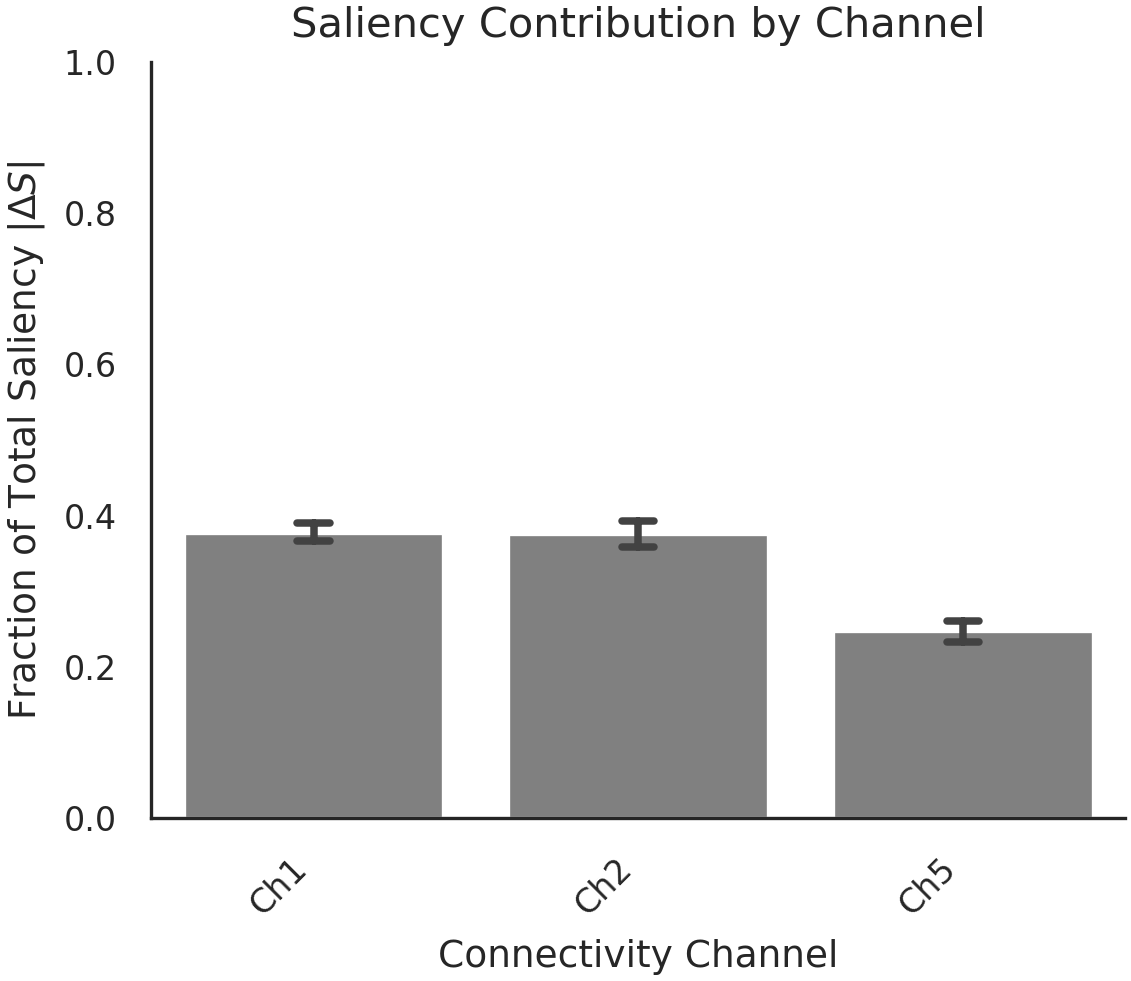

In [7]:
# ===================================================================
# CELDA CORREGIDA: CONTRIBUCIÓN POR CANAL (PROMEDIADO ENTRE FOLDS)
# ===================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuración de rutas ---
BASE_RUN_DIR = Path('./resultados_13_paper')
CLF = 'mlp'
SUFFIX = '_integrated_gradients_top50'
N_FOLDS = 5

# --- Recolectar datos de todos los folds ---
channel_contributions_rows = []
files_found = 0
for i in range(1, N_FOLDS + 1):
    file_path = BASE_RUN_DIR / f'fold_{i}/interpretability_{CLF}/channel_contributions{SUFFIX}.csv'
    if file_path.exists():
        df_contribution = pd.read_csv(file_path)
        df_contribution['fold'] = i
        channel_contributions_rows.append(df_contribution)
        files_found += 1
    else:
        print(f"⚠️ Advertencia: No se encontró el archivo para el fold {i} en: {file_path}")

# --- Proceder solo si se encontraron archivos ---
if channel_contributions_rows:
    df_contributions_all_folds = pd.concat(channel_contributions_rows, ignore_index=True)
    print(f"\n✅ Se cargaron datos de contribución de canales de {files_found} folds.")

    # --- Generar el gráfico con barras de error ---
    fig, ax = plt.subplots(figsize=(4, 3.5))
    
    sns.barplot(
        data=df_contributions_all_folds, 
        x='channel_name', 
        y='l1_norm_fraction_abs',
        color='gray',
        errorbar=('ci', 95),
        capsize=.1,
        ax=ax
    )
    
    ax.set_title('Saliency Contribution by Channel')
    ax.set_xlabel('Connectivity Channel')
    ax.set_ylabel(r'Fraction of Total Saliency $|\Delta S|$')
    ax.set_ylim(0, 1)
    
    # --- LÍNEA CORREGIDA ---
    # La rotación y alineación se controlan aquí, no en tick_params
    plt.xticks(rotation=45, ha='right')
    
    fig.tight_layout()
    
    savefig_nature(fig, FIG_DIR / 'fig_SI_channel_contributions')
    plt.show()

else:
    print("\n❌ No se encontraron archivos de contribución de canales. No se puede generar el gráfico.")

In [8]:
from sklearn.utils import check_random_state
from statsmodels.stats.multitest import multipletests

def perm_pvals_edgewise(df_subj_ig, group, strata, B=2000, seed=7):
    # df_subj_ig: DataFrame [n_subj x n_edges] con |IG_ij| por sujeto
    # group: Series (AD/CN); strata: DataFrame con Manufacturer, Sex
    rng = check_random_state(seed)
    real = df_subj_ig[group=='AD'].mean() - df_subj_ig[group=='CN'].mean()
    real = real.abs()
    counts = np.zeros_like(real, dtype=int)
    # preconstruir índices por estrato
    keys = list(zip(strata['Manufacturer'], strata['Sex']))
    uniq = sorted(set(keys))
    idx_by = {u: np.where([k==u for k in keys])[0] for u in uniq}
    y = group.values.copy()
    for b in range(B):
        y_perm = y.copy()
        for u, idx in idx_by.items():
            rng.shuffle(y_perm[idx])
        perm = df_subj_ig[y_perm=='AD'].mean() - df_subj_ig[y_perm=='CN'].mean()
        counts += (np.abs(perm) >= real).astype(int)
    p = (counts + 1) / (B + 1)
    q = multipletests(p, method='fdr_bh')[1]
    out = pd.DataFrame({'abs_deltaS': real.values, 'p': p, 'q': q}, index=df_subj_ig.columns)
    return out.sort_values('q')


In [9]:
def edge_inclusion_probability(df_rank_by_fold, K=200, B=1000, seed=13):
    rng = np.random.default_rng(seed)
    edges = sorted(set.union(*[set(df.head(K).index) for df in df_rank_by_fold.values()]))
    e2i = {e:i for i,e in enumerate(edges)}
    cnt = np.zeros(len(edges), dtype=int)
    for _ in range(B):
        for f, df in df_rank_by_fold.items():
            # re-muestra sujetos (suponiendo que guardaste IG por sujeto) y recomputa ranking...
            pass
        # incrementa cnt[e2i[edge]] si edge entra en top-K del bootstrap-meta
    return pd.Series(cnt/B, index=edges, name='EIP')


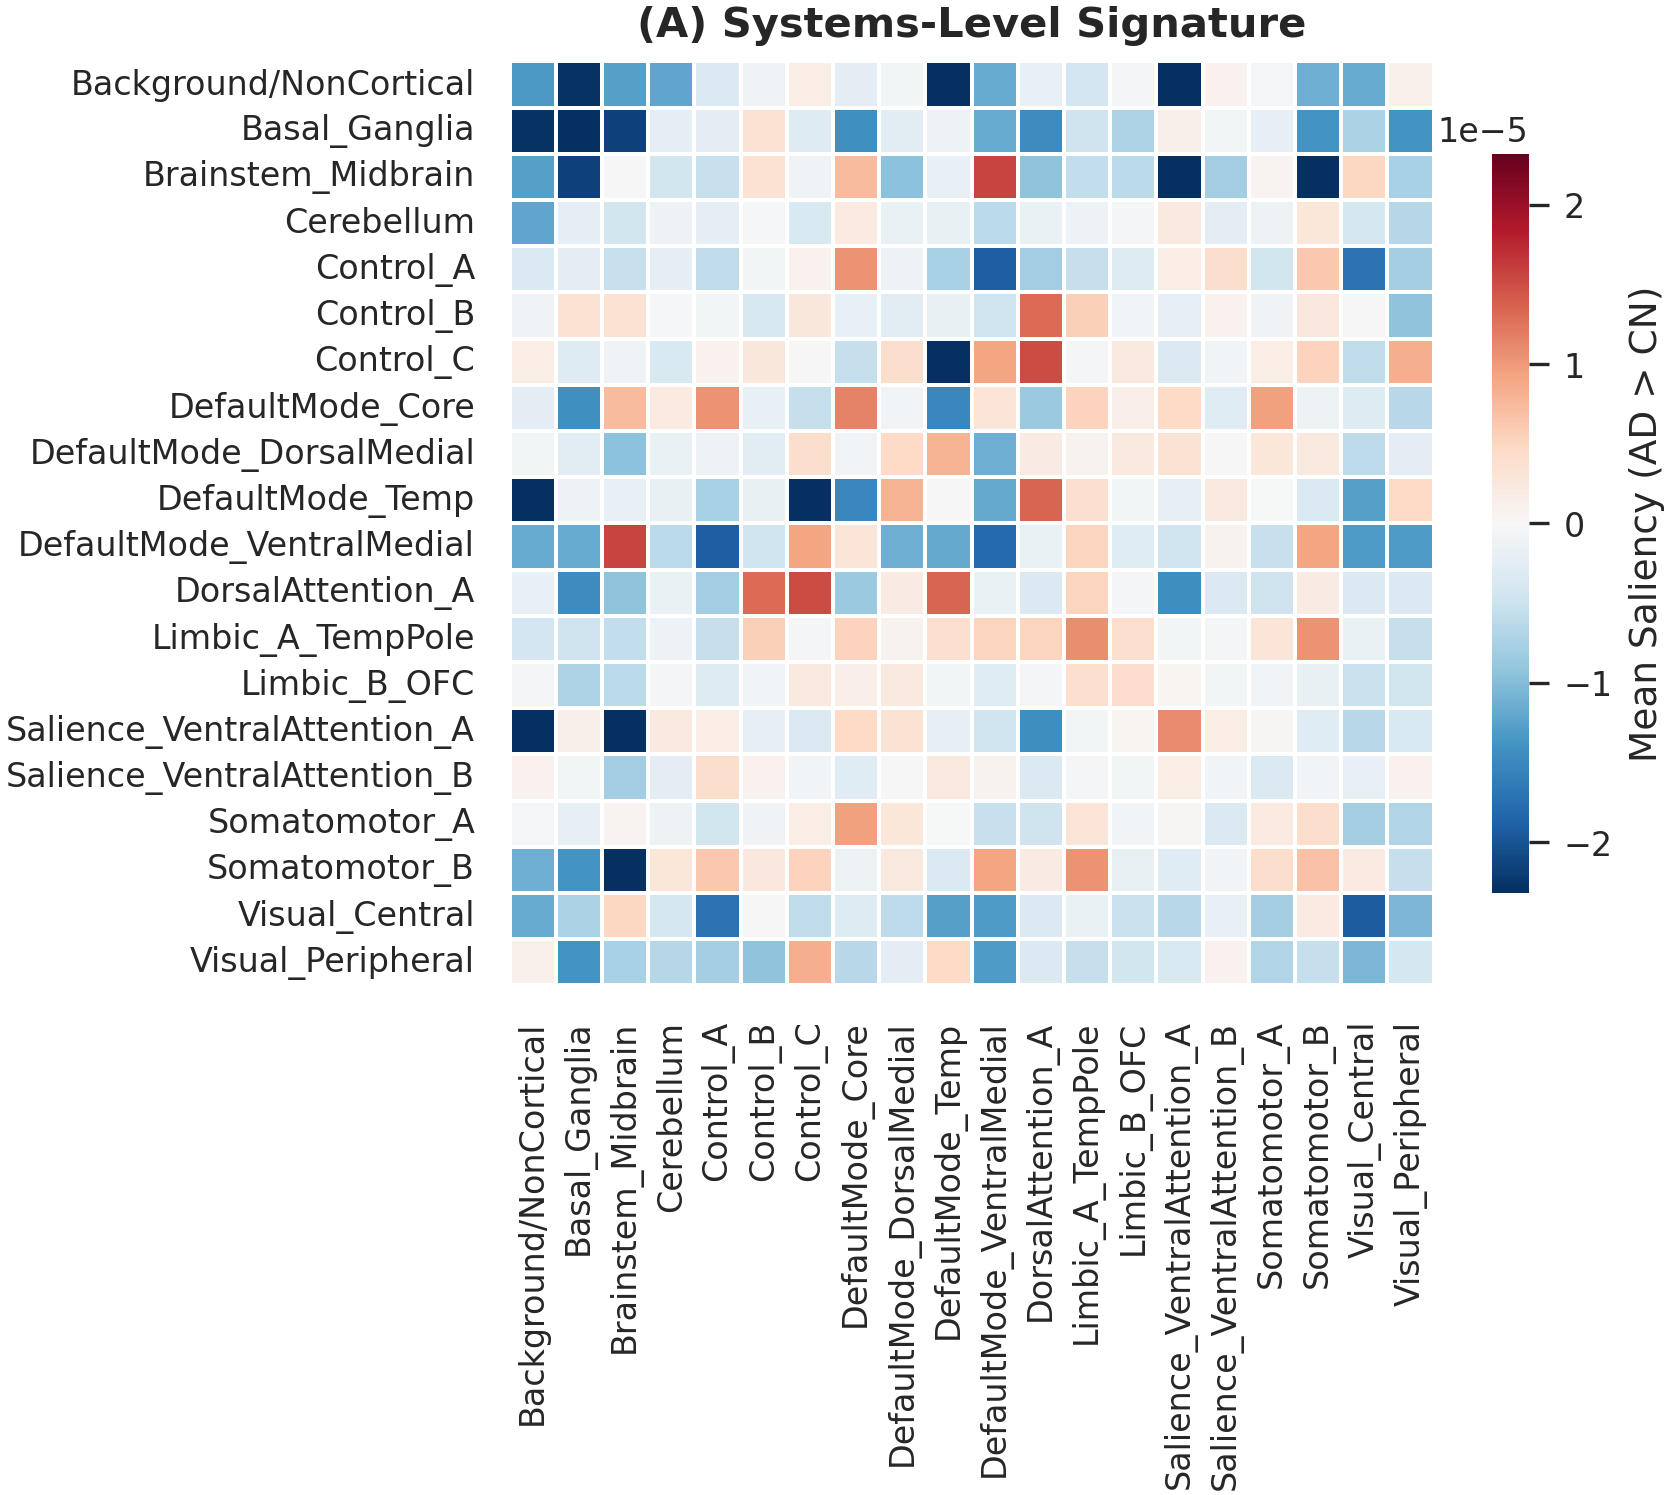

✅ Figura del Panel A guardada en: Figures_Nature/figure_A_systems_signature.svg


In [10]:
# ===================================================================
# CELDA PARA FIGURA A: Systems-Level Signature (Fold 1)
# ===================================================================

# --- Configuración ---
FOLD_TO_SHOW = 1 # Fold representativo
FIG_A_NAME = "figure_A_systems_signature"

# --- Preparación de Datos ---
df_fold_a = df_full[df_full["fold"] == FOLD_TO_SHOW].copy()
net_src_col = "src_Refined_Network" if "src_Refined_Network" in df_fold_a.columns else "src_Yeo17_Network"
net_dst_col = "dst_Refined_Network" if "dst_Refined_Network" in df_fold_a.columns else "dst_Yeo17_Network"

mat_A = df_fold_a.groupby([net_src_col, net_dst_col])["Saliency_Signed"].mean().unstack(fill_value=0)
mat_A = (mat_A + mat_A.T) / 2 # Simetrizar
network_order = sorted(mat_A.columns)
mat_A = mat_A.reindex(index=network_order, columns=network_order).fillna(0.0)

# --- Generación del Gráfico ---
fig_A, ax_A = plt.subplots(figsize=(5, 4))

# Usamos un valor máximo robusto para la escala de color
vmax_A = np.percentile(np.abs(mat_A.values), 98)

sns.heatmap(mat_A, cmap="RdBu_r", center=0, vmin=-vmax_A, vmax=vmax_A, square=True,
            cbar_kws={'label': 'Mean Saliency (AD > CN)', 'shrink': 0.8},
            ax=ax_A, linewidths=.5, linecolor='white')

ax_A.set_title("(A) Systems-Level Signature", weight="bold")
ax_A.set_xlabel("")
ax_A.set_ylabel("")
ax_A.tick_params(axis='x', rotation=90)
ax_A.tick_params(axis='y', rotation=0)

# --- Guardado en SVG ---
output_path_A = FIG_DIR / f"{FIG_A_NAME}.svg"
fig_A.savefig(output_path_A, format='svg', bbox_inches="tight")
plt.show()

print(f"✅ Figura del Panel A guardada en: {output_path_A}")

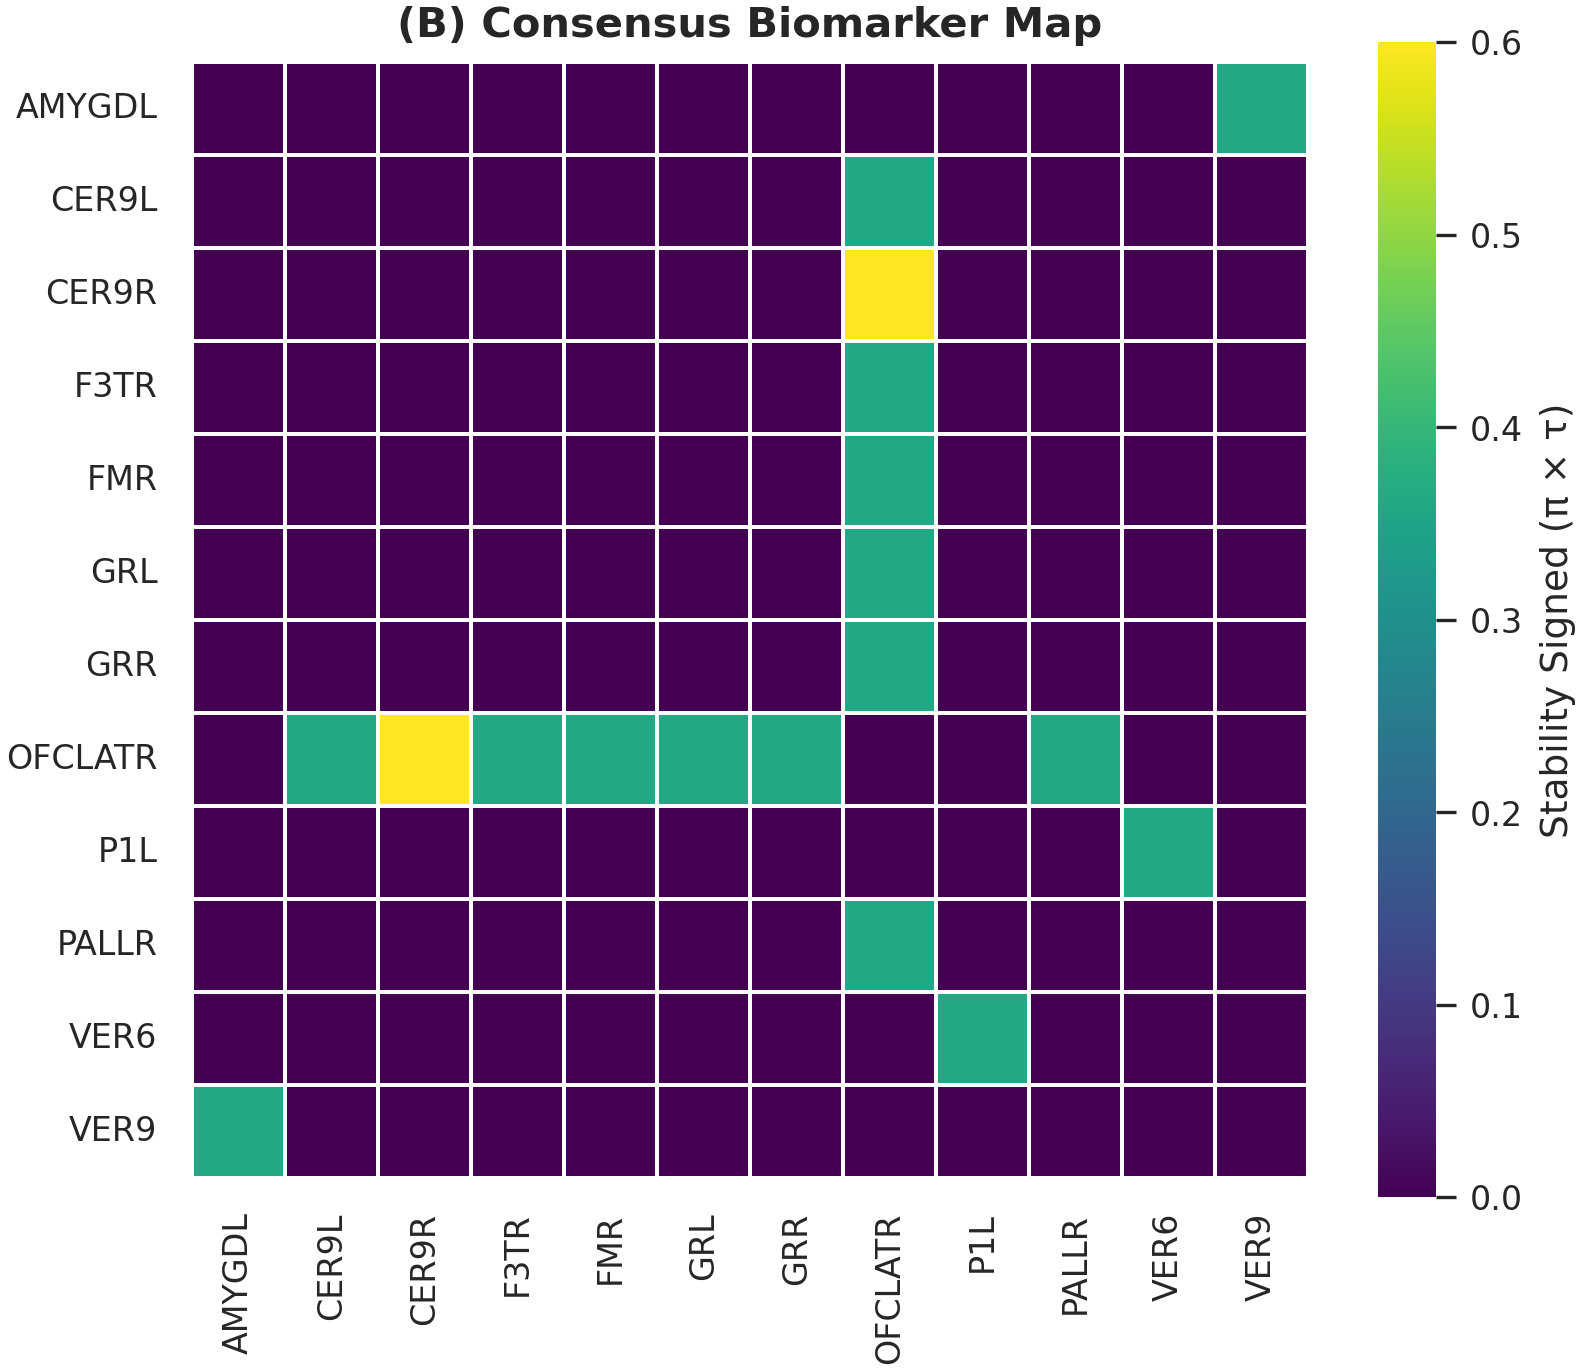

✅ Figura del Panel B guardada en: Figures_Nature/figure_B_consensus_map.svg


In [11]:
# ===================================================================
# CELDA PARA FIGURA B: Consensus Biomarker Map
# ===================================================================

# --- Configuración ---
FIG_B_NAME = "figure_B_consensus_map"

# --- Preparación de Datos ---
# Asegúrate de que 'consensus_set' ya ha sido calculado
rois_B = sorted(list(set(roi for conn_tuple in consensus_set.index for roi in conn_tuple)))
mat_B = pd.DataFrame(0.0, index=rois_B, columns=rois_B)
for (src, dst), row in consensus_set.iterrows():
    mat_B.loc[src, dst] = mat_B.loc[dst, src] = row['Signed']

# --- Generación del Gráfico ---
fig_B, ax_B = plt.subplots(figsize=(6, 5))

sns.heatmap(mat_B, cmap="viridis", square=True,
            cbar_kws={'label': 'Stability Signed (π × τ)'},
            ax=ax_B, linewidths=.5, linecolor='white')

ax_B.set_title("(B) Consensus Biomarker Map", weight="bold")
ax_B.set_xlabel("")
ax_B.set_ylabel("")
ax_B.tick_params(axis='x', rotation=90)
ax_B.tick_params(axis='y', rotation=0)

# --- Guardado en SVG ---
output_path_B = FIG_DIR / f"{FIG_B_NAME}.svg"
fig_B.savefig(output_path_B, format='svg', bbox_inches="tight")
plt.show()

print(f"✅ Figura del Panel B guardada en: {output_path_B}")

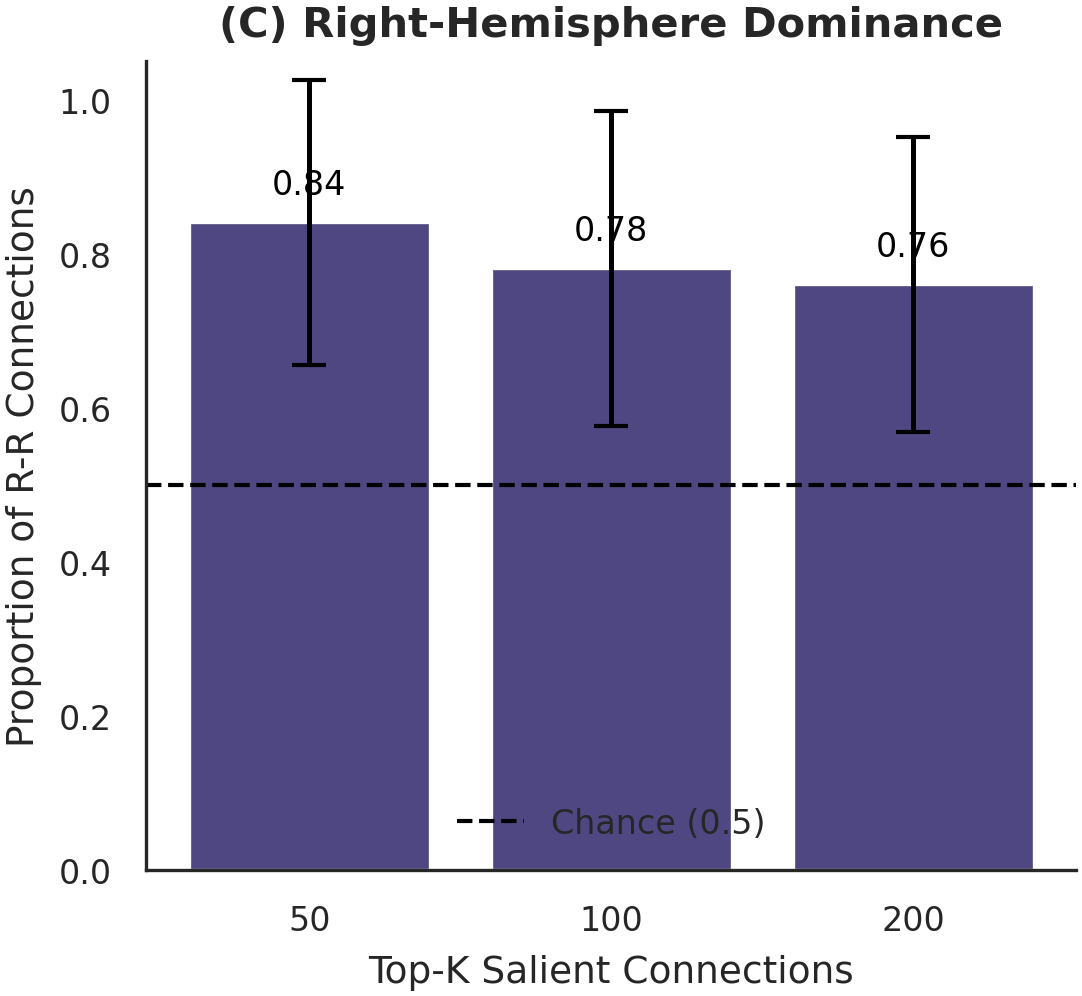

✅ Figura del Panel C guardada en: Figures_Nature/figure_C_hemisphere_dominance.svg


In [12]:
# ===================================================================
# CELDA PARA FIGURA C: Right-Hemisphere Dominance
# ===================================================================
from scipy.stats import t

# --- Configuración ---
FIG_C_NAME = "figure_C_hemisphere_dominance"

# --- Preparación de Datos ---
# Asegúrate de que 'df_lat_plot' ya ha sido calculado
agg_C = df_lat_plot.groupby("TopK")["p_RR"].agg(["mean", "count", "std"]).reset_index()
agg_C["sem"] = agg_C["std"] / np.sqrt(agg_C["count"])
agg_C["ci"]  = t.ppf(0.975, df=agg_C["count"] - 1) * agg_C["sem"]

# --- Generación del Gráfico ---
fig_C, ax_C = plt.subplots(figsize=(4, 3.5))

sns.barplot(data=agg_C, x="TopK", y="mean", color="darkslateblue", ax=ax_C)
ax_C.errorbar(agg_C["TopK"].astype(str), agg_C["mean"], yerr=agg_C["ci"], fmt="none", capsize=4, ecolor="black")

ax_C.axhline(0.5, ls="--", c="black", lw=1, label="Chance (0.5)")
ax_C.set_ylim(0, 1.05)
ax_C.set_xlabel("Top-K Salient Connections")
ax_C.set_ylabel("Proportion of R-R Connections")
ax_C.set_title("(C) Right-Hemisphere Dominance", weight="bold")
ax_C.legend(frameon=False)

# Anotar los valores medios en las barras para mayor claridad
for p in ax_C.patches:
    ax_C.annotate(f"{p.get_height():.2f}",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points',
                   fontsize=8, color='black')

# --- Guardado en SVG ---
output_path_C = FIG_DIR / f"{FIG_C_NAME}.svg"
fig_C.savefig(output_path_C, format='svg', bbox_inches="tight")
plt.show()

print(f"✅ Figura del Panel C guardada en: {output_path_C}")

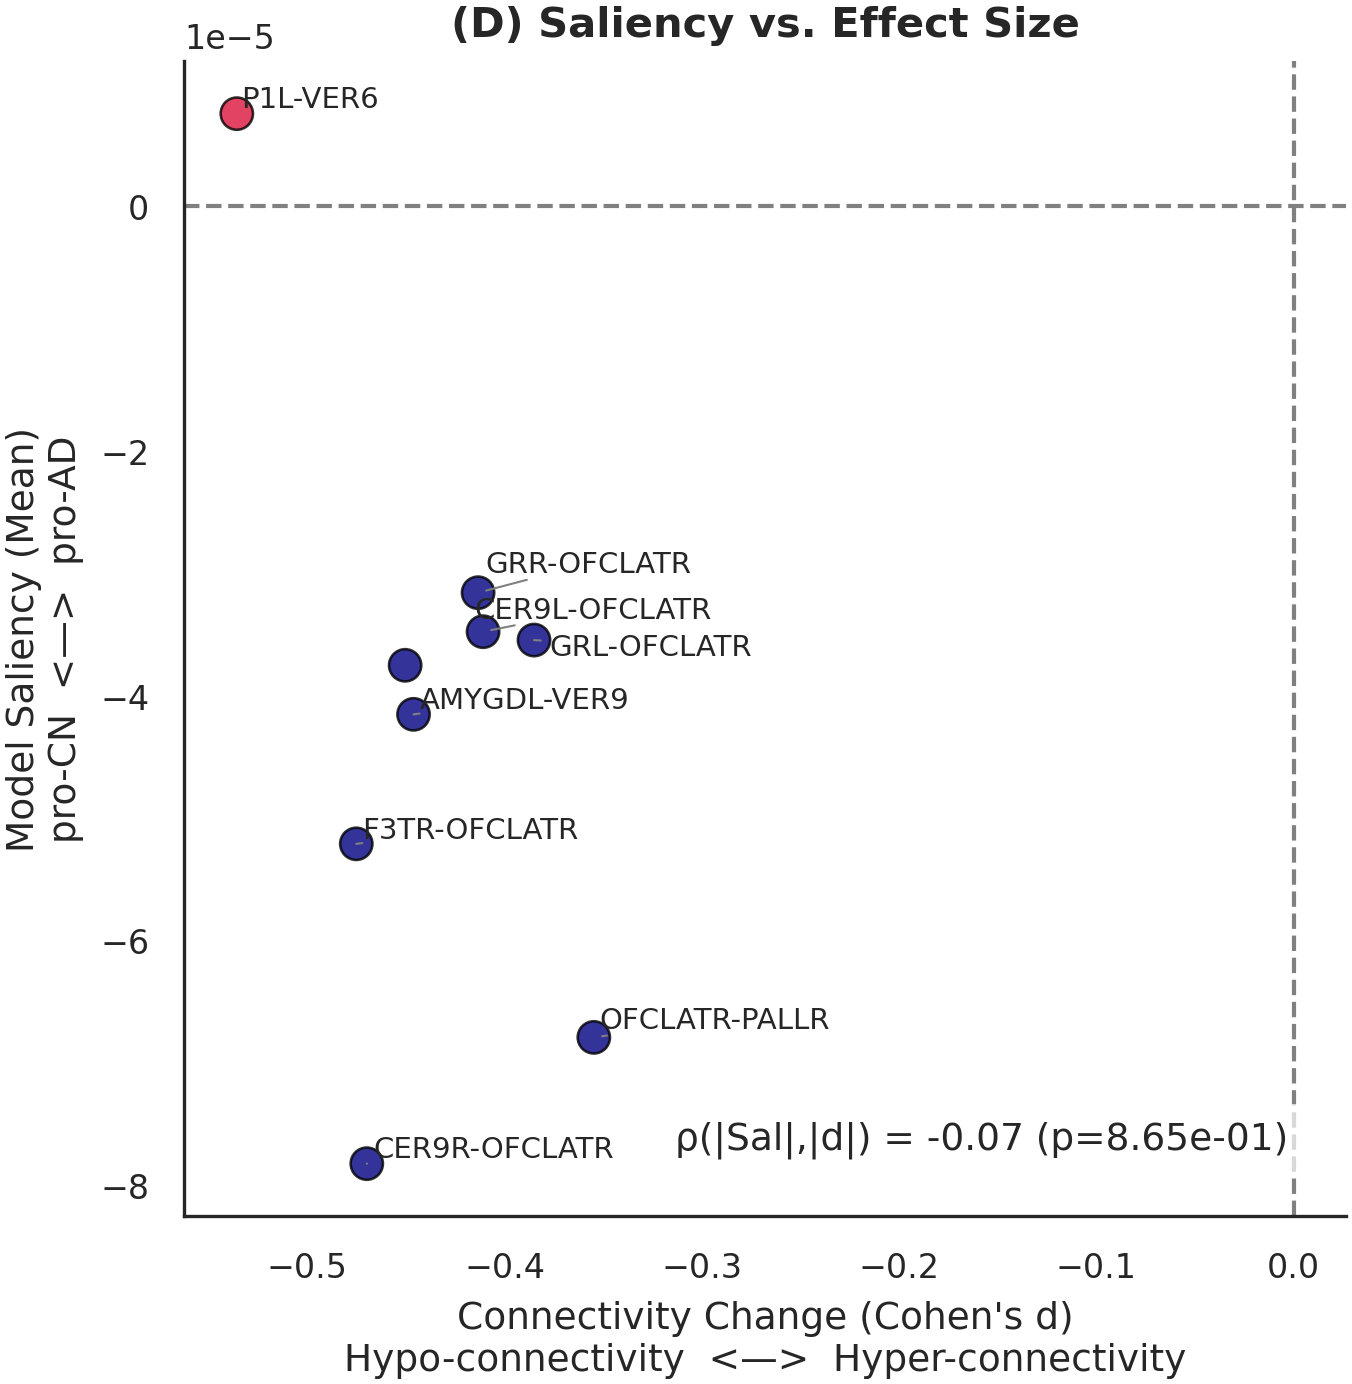

✅ Figura del Panel D guardada en: Figures_Nature/figure_D_saliency_vs_effect.svg


In [13]:
# ===================================================================
# CELDA PARA FIGURA D: Saliency vs. Effect Size (FIX)
# ===================================================================
from scipy.stats import spearmanr
try:
    from adjustText import adjust_text
    ADJUST_TEXT_AVAILABLE = True
except ImportError:
    ADJUST_TEXT_AVAILABLE = False
    def adjust_text(texts, **kwargs): pass

FIG_D_NAME = "figure_D_saliency_vs_effect"

# --- Preparación de Datos (usa df_cohen_all) ---
df_mean_sal = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("sal")
cohen_df = df_cohen_all[["mean_cohen_d"]].rename(columns={"mean_cohen_d": "cohen_d"})

# Asegurar mismo índice y filtrar al consensus_set
df_qc = (
    pd.concat([df_mean_sal, cohen_df], axis=1)
      .dropna()
      .loc[df_mean_sal.index.intersection(consensus_set.index)]
)

# Seguridad: si quedara vacío, no crashea
if len(df_qc) == 0:
    print("⚠️ df_qc está vacío. Revisa que consensus_set y df_cohen_all compartan índices.")
    fig_D, ax_D = plt.subplots(figsize=(5, 5))
    ax_D.text(0.5, 0.5, "No data after merge", ha='center', va='center', style='italic', color='grey')
    ax_D.set_xticks([]); ax_D.set_yticks([])
    output_path_D = FIG_DIR / f"{FIG_D_NAME}.svg"
    fig_D.savefig(output_path_D, format='svg', bbox_inches="tight")
    plt.show()
else:
    rho, pval = spearmanr(df_qc["sal"].abs(), df_qc["cohen_d"].abs())

    fig_D, ax_D = plt.subplots(figsize=(5, 5))
    sns.scatterplot(
        data=df_qc, x="cohen_d", y="sal",
        s=60, edgecolor="black", alpha=0.8, ax=ax_D,
        hue=(df_qc['sal'] > 0), palette={True:'crimson', False:'navy'}, legend=False
    )

    ax_D.axhline(0, c="grey", ls="--", lw=1)
    ax_D.axvline(0, c="grey", ls="--", lw=1)
    ax_D.set_title("(D) Saliency vs. Effect Size", weight="bold")
    ax_D.set_xlabel("Connectivity Change (Cohen's d)\nHypo-connectivity  <—>  Hyper-connectivity")
    ax_D.set_ylabel("Model Saliency (Mean)\npro-CN  <—>  pro-AD")

    ax_D.text(0.95, 0.05, f'ρ(|Sal|,|d|) = {rho:.2f} (p={pval:.2e})',
              transform=ax_D.transAxes, ha='right', va='bottom', fontsize=9,
              bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Etiquetar extremos
    pts = pd.concat([df_qc.nlargest(4, 'sal'), df_qc.nsmallest(4, 'sal')])
    texts = [ax_D.text(r["cohen_d"], r["sal"], f"{i[0]}-{i[1]}", fontsize=7)
             for i, r in pts.iterrows()]
    if ADJUST_TEXT_AVAILABLE:
        adjust_text(texts, ax=ax_D, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    output_path_D = FIG_DIR / f"{FIG_D_NAME}.svg"
    fig_D.savefig(output_path_D, format='svg', bbox_inches="tight")
    plt.show()

print(f"✅ Figura del Panel D guardada en: {output_path_D}")


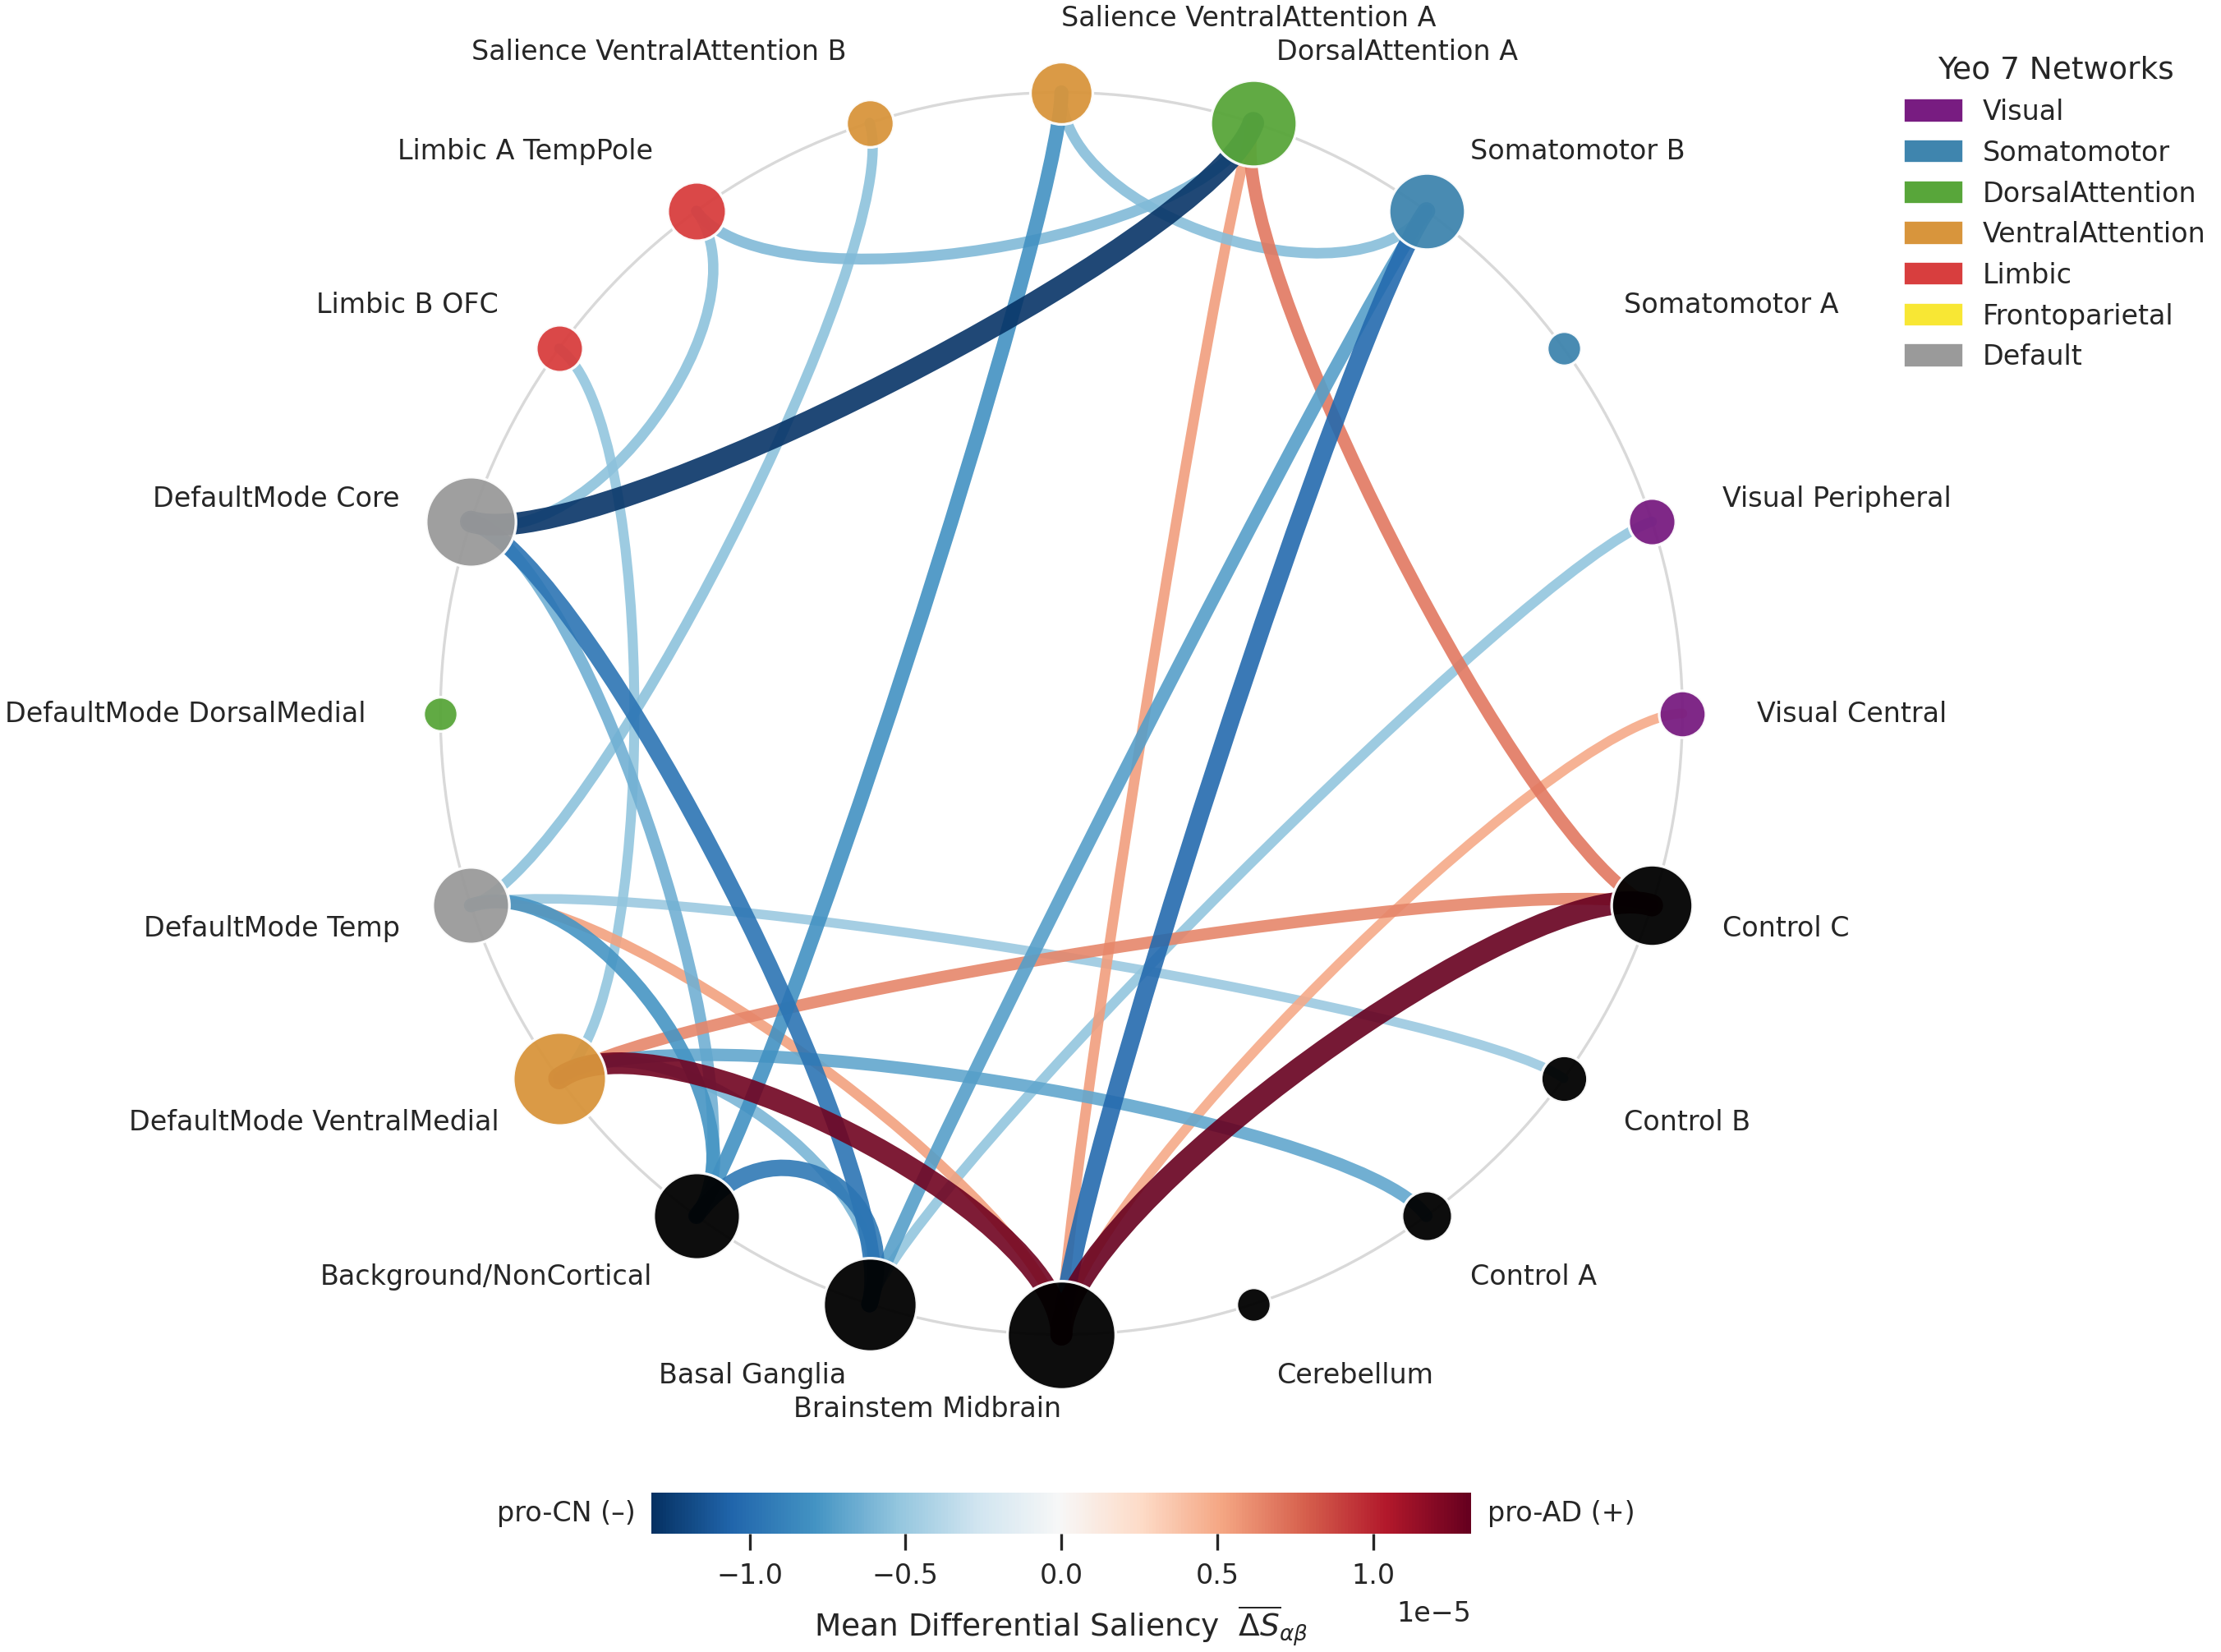

In [14]:
# ======================= CELDA — Chord Yeo↔Yeo (VERSIÓN FINAL CON SVG CORREGIDO) =======================
import pathlib
from datetime import datetime as _dt
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_cmaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch, Circle
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ======================== PARÁMETROS DE LA FIGURA ========================
TOP_K_PAIRS = 24
AGGREGATE_ACROSS_FOLDS = True
FOLD_TO_SHOW = 1
CMAP = 'RdBu_r'
FIGSIZE = (7.2, 7.2)
R_BASE, R_LABEL = 1.00, 1.12
CURVE_INSET = 0.80
ORDER_MODE = 'yeo'
NODE_COLOR_MODE = 'yeo'
MIN_ABS_WEIGHT = 0.0
outname = FIG_DIR / f"fig_YeoChord_{'allfolds' if AGGREGATE_ACROSS_FOLDS else f'fold{FOLD_TO_SHOW}'}_{_dt.now().strftime('%Y%m%d_%H%M')}"

# ======================== LÓGICA DE PLOTEO (Función Principal) ========================
YEO7_ORDER = ['Visual', 'Somatomotor', 'DorsalAttention', 'VentralAttention', 
              'Limbic', 'Frontoparietal', 'Default']
YEO_COLOR_MAP = {
    'visual': '#781C81', 'somato': '#3F85AE', 'dorsal': '#58A63A', 
    'ventral': '#D8953C', 'limbic': '#D83E3E', 'fronto': '#F8E734', 'default': '#9A9A9A'
}

def guess_yeo_color(name: str, default='black'):
    n = name.lower()
    for key, col in YEO_COLOR_MAP.items():
        if key in n: return col
    return default

def _bezier_chord(ax, p1, p2, lw, color, alpha=0.9, inset=0.80):
    ctrl1, ctrl2 = p1 * inset, p2 * inset
    path = MplPath([p1, ctrl1, ctrl2, p2], [MplPath.MOVETO, MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4])
    ax.add_patch(PathPatch(path, facecolor='none', edgecolor=color, lw=lw, alpha=alpha, capstyle='round'))

# ---- Preparación de datos (sin cambios) ----
ns = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
nd = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'
_df = df_full[[ns, nd, 'Saliency_Signed'] + (['fold'] if 'fold' in df_full.columns else [])].dropna()
if not AGGREGATE_ACROSS_FOLDS and 'fold' in _df.columns:
    _df = _df[_df['fold'] == FOLD_TO_SHOW].copy()
title_suffix = 'mean across folds' if AGGREGATE_ACROSS_FOLDS else f'fold {FOLD_TO_SHOW}'
mat = _df.groupby([ns, nd])['Saliency_Signed'].mean().unstack(fill_value=0.0)
mat = (mat + mat.T) / 2
networks = sorted(mat.index.union(mat.columns))
mat = mat.reindex(index=networks, columns=networks).fillna(0.0)
edges = []
for i, a in enumerate(networks):
    for j, b in enumerate(networks):
        if j <= i: continue
        w = float(mat.loc[a, b])
        if abs(w) >= MIN_ABS_WEIGHT:
            edges.append((a, b, w, abs(w)))
if not edges: raise ValueError("No hay pares de redes para graficar.")
k = int(min(TOP_K_PAIRS, len(edges)))
edges_top = sorted(edges, key=lambda t: t[3], reverse=True)[:k]
node_strength = pd.Series(0.0, index=networks)
for a, b, w, aw in edges_top:
    node_strength[a] += aw; node_strength[b] += aw
if ORDER_MODE == 'yeo':
    def _get_order_key(name):
        n_lower = name.lower()
        for idx, canon in enumerate(YEO7_ORDER):
            if canon.lower() in n_lower: return (idx, name)
        return (len(YEO7_ORDER), name)
    net_order = sorted(networks, key=_get_order_key)
else:
    net_order = sorted(networks)
theta = np.linspace(0, 2*np.pi, len(net_order), endpoint=False)
pos = {net: np.array([R_BASE*np.cos(t), R_BASE*np.sin(t)]) for net, t in zip(net_order, theta)}
vmax = np.percentile([aw for *_, aw in edges_top], 98) if edges_top else 1.0
if not np.isfinite(vmax) or vmax <= 1e-6: vmax = 1.0
norm = Normalize(vmin=-vmax, vmax=vmax)
cmap = mpl_cmaps.get_cmap(CMAP)
max_abs = max((aw for *_, aw in edges_top), default=1.0)
def width_from_abs(aw):
    return float(np.clip(0.6 + 6.0 * (aw / (max_abs + 1e-12)), 0.6, 6.5))

# ---- Figura ----
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_aspect('equal'); ax.axis('off')
ax.add_patch(Circle((0,0), R_BASE, facecolor='none', edgecolor='0.85', lw=0.8, zorder=0))

for a, b, w, aw in sorted(edges_top, key=lambda t: t[3]):
    _bezier_chord(ax, pos[a], pos[b], lw=width_from_abs(aw), color=cmap(norm(w)), inset=CURVE_INSET)

for net in net_order:
    xy = pos[net]
    facecolor = guess_yeo_color(net) if NODE_COLOR_MODE == 'yeo' else 'black'
    size = 100 + 900 * (node_strength.get(net, 0) / node_strength.max() if node_strength.max() > 0 else 0)
    ax.scatter([xy[0]], [xy[1]], s=size, zorder=5, edgecolor='white', linewidth=0.8, color=facecolor, alpha=0.95)
    ang = np.arctan2(xy[1], xy[0])
    lx, ly = R_LABEL*np.cos(ang), R_LABEL*np.sin(ang)
    ax.text(lx, ly, net.replace('_',' '), fontsize=8, ha='left' if lx >= 0 else 'right', va='center')

# --- LEYENDA PARA LAS REDES YEO ---
key_map = {
    'Visual': 'visual', 'Somatomotor': 'somato', 'DorsalAttention': 'dorsal',
    'VentralAttention': 'ventral', 'Limbic': 'limbic', 'Frontoparietal': 'fronto', 'Default': 'default'
}
legend_handles = [mpatches.Patch(color=YEO_COLOR_MAP[key_map[name]], label=name) for name in YEO7_ORDER]
ax.legend(handles=legend_handles, 
          title='Yeo 7 Networks', 
          bbox_to_anchor=(1.1, 1.0),
          loc='upper left',         
          fontsize=8,
          title_fontsize=9,
          frameon=False)            

# --- COLORBAR HORIZONTAL ABAJO (FIX SVG) ---
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(-vmax, vmax, 256))  # ⟵ CLAVE: da “datos” al mapeador

cax = inset_axes(ax, width="60%", height="3%", loc='lower center', borderpad=-5)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r'Mean Differential Saliency  $\overline{\Delta S}_{\alpha\beta}$', fontsize=9)
cbar.solids.set_edgecolor("face")       # evita líneas en el gradiente
cbar.outline.set_visible(False)
# (opcional) rasterizar SOLO el gradiente si ves banding en Illustrator
# cbar.solids.set_rasterized(True)

cbar.ax.text(1.02, 0.5, 'pro-AD (+)', transform=cbar.ax.transAxes, ha='left', va='center', fontsize=8)
cbar.ax.text(-0.02, 0.5, 'pro-CN (–)', transform=cbar.ax.transAxes, ha='right', va='center', fontsize=8)

# --- Guardado ---
savefig_nature(fig, outname)  # pdf/png como ya tenías
fig.savefig(outname.with_suffix(".svg"), format='svg', bbox_inches="tight")  # ⟵ sin 'rasterized'


In [15]:
# === NUEVA CELDA: Robust hubs agregados (grado-controlado) ===
import pandas as pd, numpy as np
from pathlib import Path

Ks = (50, 100, 200)
hub_rows = []

for fold in range(1, N_FOLDS + 1):
    for K in Ks:
        path = BASE_RUN_DIR / f"fold_{fold}/interpretability_{CLF}/node_robust_hubs_top{K}{SUFFIX}.csv"
        if not path.exists():
            print(f"⚠️ Falta: {path}")
            continue
        df = pd.read_csv(path)
        # aseguramos columnas esperadas
        assert {'node','degree','strength','residual_strength'}.issubset(df.columns), "CSV hubs no tiene columnas esperadas"
        df = df.sort_values('residual_strength', ascending=False).reset_index(drop=True)
        df['fold'] = fold
        df['K'] = K
        df['rank_resid'] = np.arange(1, len(df)+1)
        # guardamos top-10 por robustez
        hub_rows.append(df.head(10)[['node','residual_strength','rank_resid','fold','K']])

if not hub_rows:
    raise RuntimeError("No se encontraron CSVs de hubs. Corre interpretar_fold_paper.py (saliency) para generarlos.")

hubs_agg = pd.concat(hub_rows, ignore_index=True)

# métricas de “epicentro”
summary = (
    hubs_agg
    .groupby('node')
    .agg(
        top3_hits = ('rank_resid', lambda s: int((s <= 3).sum())),
        mean_rank = ('rank_resid', 'mean'),
        mean_resid= ('residual_strength', 'mean'),
        n_lists   = ('rank_resid', 'size')
    )
    .sort_values(['top3_hits','mean_resid'], ascending=[False, False])
)

display(summary.head(20))

# ✅ chequeo específico de HIPPOR y cerebelo
roi_focus = [r for r in summary.index if ('HIPPOR' in r) or ('CER' in r)]
display(summary.loc[roi_focus].sort_values(['top3_hits','mean_resid'], ascending=[False,False]).head(20))


,top3_hits,mean_rank,mean_resid,n_lists
node,,,,
OFCLATR,6,1.500000,0.000180,6
CER9R,6,1.833333,0.000137,6
FUSIR,6,1.833333,0.000122,6
O3R,3,1.666667,0.000161,3
CINMR,3,1.333333,0.000110,3
LINGR,3,3.400000,0.000110,5
CER8L,3,3.500000,0.000105,4
HIPPOR,3,2.333333,0.000095,3
COBR,3,4.600000,0.000063,5


,top3_hits,mean_rank,mean_resid,n_lists
node,,,,
CER9R,6,1.833333,0.000137,6
CER8L,3,3.500000,0.000105,4
HIPPOR,3,2.333333,0.000095,3
CER3L,0,6.666667,0.000070,3
CERCRU2L,0,8.000000,0.000065,3
CERCRU1R,0,8.333333,0.000050,3
CERCRU2R,0,6.500000,0.000044,2
CER10R,0,8.000000,0.000040,2


In [16]:
# === NUEVA CELDA: Lateralización con conteos y test binomial ===
import pandas as pd, numpy as np
from scipy.stats import binomtest

def rr_ll_counts(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    out = []
    for f, g in top.groupby("fold", observed=True):
        rr = (g["hemi_src"] == "R").sum()
        ll = (g["hemi_src"] == "L").sum()
        out.append({"fold": int(f), "K": K, "RR": rr, "LL": ll})
    return pd.DataFrame(out)

counts = pd.concat([rr_ll_counts(df_lat_clean, K) for K in (50, 100, 200)], ignore_index=True)

stats = []
for K, g in counts.groupby('K'):
    rr_total = g['RR'].sum()
    ll_total = g['LL'].sum()
    n = rr_total + ll_total
    prop = rr_total / max(n, 1)
    p = binomtest(rr_total, n, p=0.5, alternative='greater').pvalue if n > 0 else np.nan
    stats.append({"TopK": K, "RR_total": rr_total, "LL_total": ll_total, "prop_RR": prop, "p_binom": p})
stats_df = pd.DataFrame(stats).sort_values('TopK')
display(stats_df)

# (opcional) imprimir frase lista para el paper
for r in stats_df.itertuples():
    print(f"K={r.TopK}: R–R={r.RR_total}, L–L={r.LL_total}, proporción R–R={r.prop_RR:.2f}, binomial p={r.p_binom:.3g}")


,TopK,RR_total,LL_total,prop_RR,p_binom
0,50,101,18,0.848739,1.682885e-15
1,100,170,45,0.790698,1.372516e-18
2,200,329,103,0.761574,6.591267e-29


K=50: R–R=101, L–L=18, proporción R–R=0.85, binomial p=1.68e-15
K=100: R–R=170, L–L=45, proporción R–R=0.79, binomial p=1.37e-18
K=200: R–R=329, L–L=103, proporción R–R=0.76, binomial p=6.59e-29


,index,channel_name,mean,std,count,sem,ci95
0,0,Ch1,0.376895,0.015508,5,0.006936,0.019256
1,1,Ch2,0.375209,0.022421,5,0.010027,0.027839
2,2,Ch5,0.247896,0.017437,5,0.007798,0.021651


""


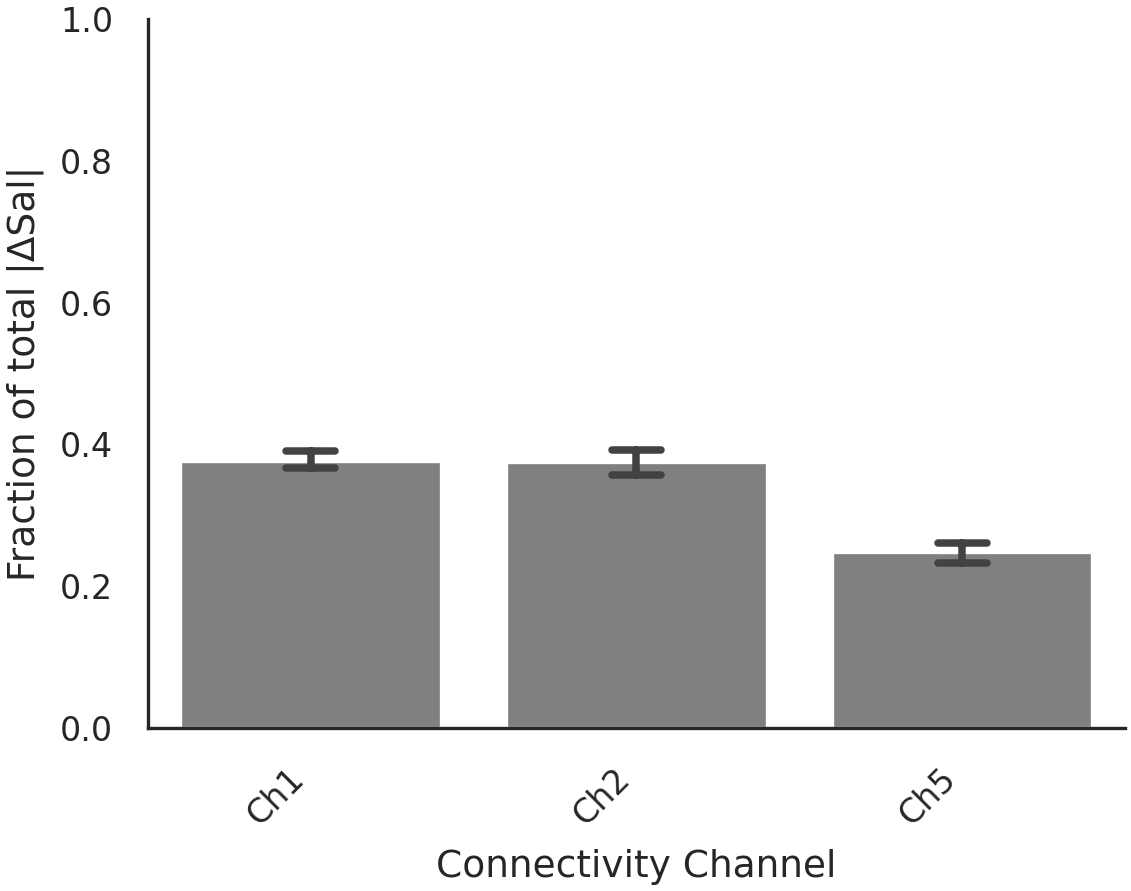

In [17]:
# === NUEVA CELDA: Contribución por canal con IC95 + Wilcoxon apareado ===
import numpy as np, pandas as pd
from scipy.stats import t, wilcoxon
import seaborn as sns, matplotlib.pyplot as plt

assert 'df_contributions_all_folds' in globals(), "Ejecuta antes la celda que concatena channel_contributions de los 5 folds."

# Resumen por canal
agg = (df_contributions_all_folds
       .groupby('channel_name', as_index=False)['l1_norm_fraction_abs']
       .agg(['mean','std','count'])
       .reset_index())
agg['sem'] = agg['std'] / np.sqrt(agg['count'])
agg['ci95'] = t.ppf(0.975, df=agg['count'] - 1) * agg['sem']
display(agg)

# Contraste apareado por fold: no lineales vs Pearson
pivot = df_contributions_all_folds.pivot_table(index='fold', columns='channel_name', values='l1_norm_fraction_abs')
pear = pivot.get('Pearson_Full_FisherZ_Signed')
mi   = pivot.filter(like='MI').iloc[:,0] if any(pivot.columns.str.contains('MI')) else None
dc   = pivot.filter(like='DistanceCorr').iloc[:,0] if any(pivot.columns.str.contains('DistanceCorr')) else None

tests = []
if mi is not None and pear is not None:
    stat,p = wilcoxon(mi, pear, alternative='greater')
    tests.append({'comparison':'MI_kNN > Pearson', 'p_wilcoxon':p, 'median_diff': (mi-pear).median()})
if dc is not None and pear is not None:
    stat,p = wilcoxon(dc, pear, alternative='greater')
    tests.append({'comparison':'DistanceCorr > Pearson', 'p_wilcoxon':p, 'median_diff': (dc-pear).median()})
display(pd.DataFrame(tests))

# Figura compacta para el panel C (media ± IC95)
fig, ax = plt.subplots(figsize=(4, 3.2))
sns.barplot(data=df_contributions_all_folds, x='channel_name', y='l1_norm_fraction_abs',
            errorbar=('ci', 95), color='gray', capsize=.15, ax=ax)
ax.set_xlabel('Connectivity Channel'); ax.set_ylabel('Fraction of total |ΔSal|'); ax.set_ylim(0,1)
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
savefig_nature(fig, FIG_DIR / 'fig_signature_properties_panelC_channels')
plt.show()


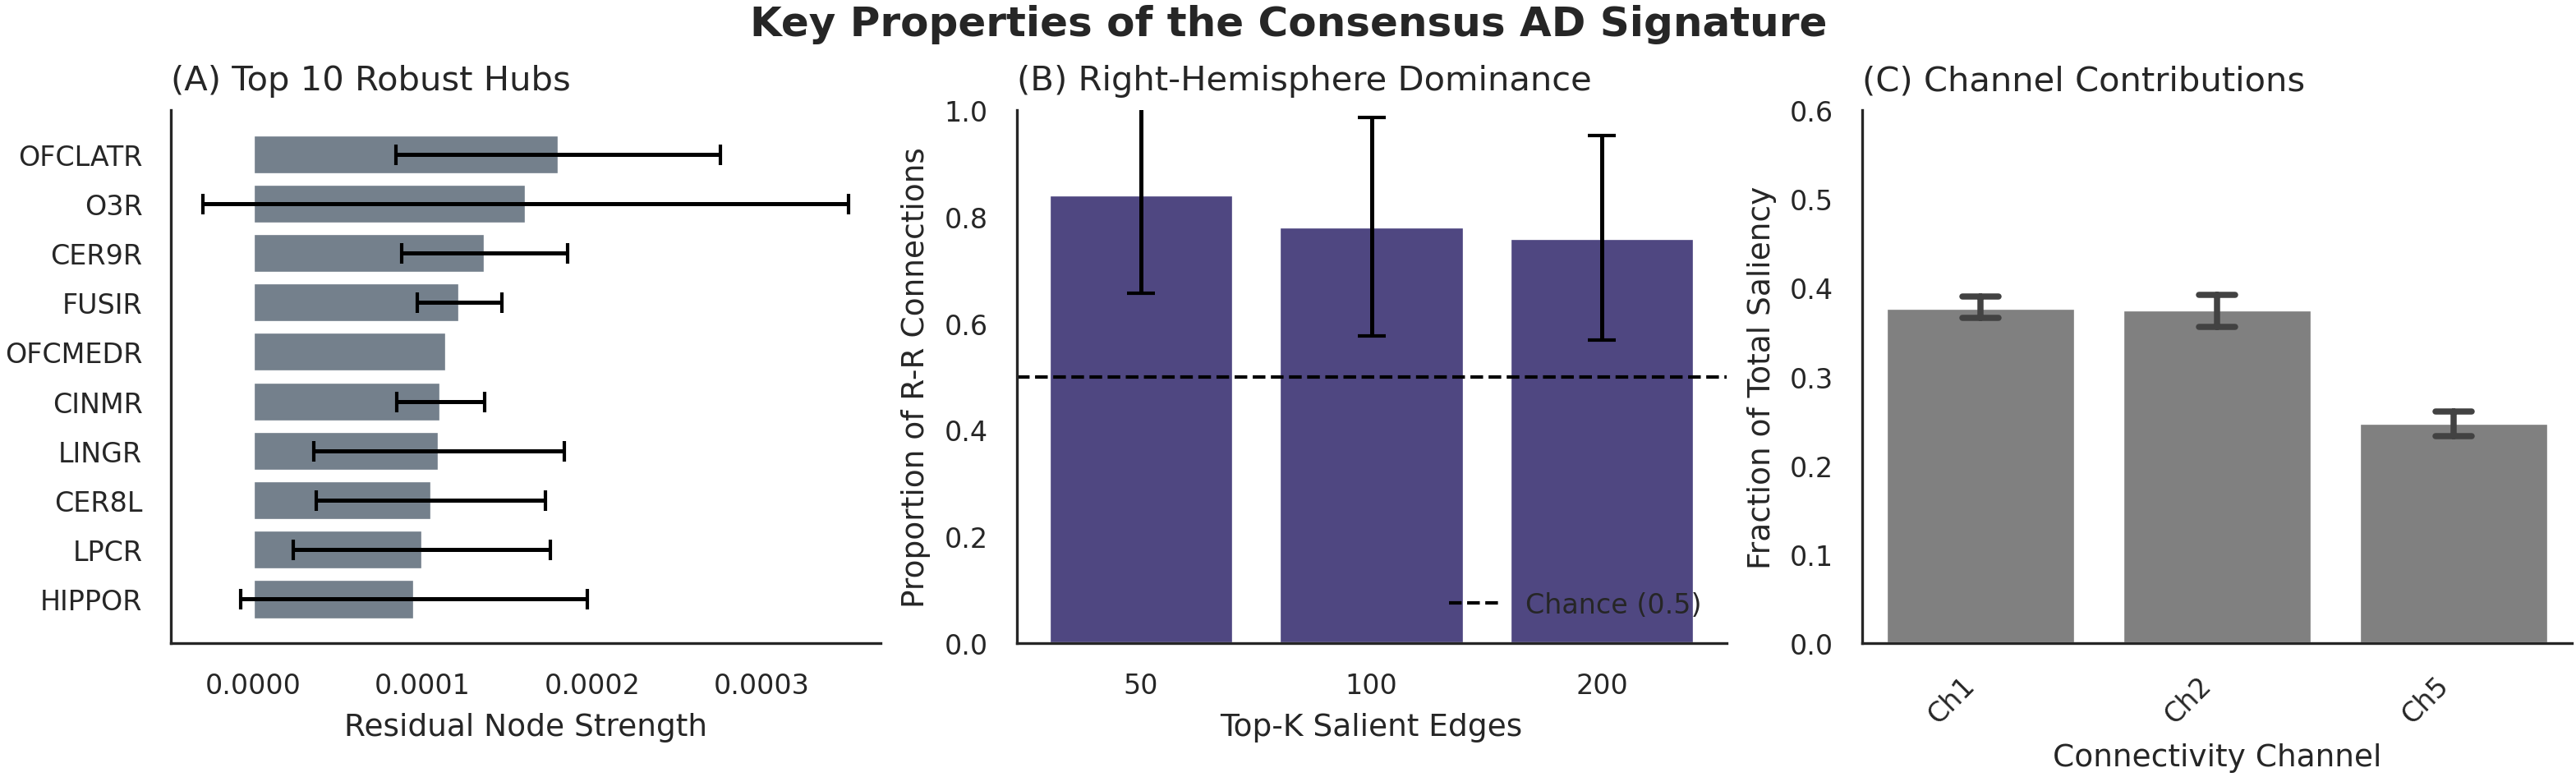

✅ Figura compuesta 'signature_properties' guardada en: Figures_Nature/signature_properties.pdf


In [18]:
# ==============================================================================
# CELDA FINAL: Figura compuesta "signature_properties" (A-B-C) para Q1
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

# --- Verificar que los datos necesarios existen ---
assert 'hubs_agg' in globals(), "Ejecuta la celda de análisis de hubs primero."
assert 'df_lat_plot' in globals(), "Ejecuta la celda 3 (análisis de estabilidad) primero."
assert 'df_contributions_all_folds' in globals(), "Ejecuta la celda de contribución de canales primero."

# ---- (A) Preparar datos para el panel de Hubs ----
topA = (
    hubs_agg
    .groupby('node')
    .agg(mean_resid=('residual_strength', 'mean'),
         sem=('residual_strength', lambda s: s.std(ddof=1) / np.sqrt(s.size) if s.size > 1 else 0),
         n=('residual_strength', 'size'))
    .sort_values('mean_resid', ascending=False)
    .head(10)
    .reset_index()
)
topA['ci95'] = t.ppf(0.975, df=topA['n'] - 1) * topA['sem']

# ---- (B) Preparar datos para el panel de Lateralización ----
agg_B = df_lat_plot.groupby("TopK")["p_RR"].agg(["mean", "count", "std"]).reset_index()
agg_B["sem"] = agg_B["std"] / np.sqrt(agg_B["count"])
agg_B["ci95"] = t.ppf(0.975, df=agg_B["count"] - 1) * agg_B["sem"]

# ---- (C) Preparar datos para el panel de Canales ----
# Los datos ya están en 'df_contributions_all_folds'

# ---- Creación de la Figura Compuesta ----
fig, axs = plt.subplots(1, 3, figsize=(10.5, 3.2), constrained_layout=True)
fig.suptitle('Key Properties of the Consensus AD Signature', fontsize=12, weight='bold')

# ---------- Panel A: Hubs ----------
sns.barplot(ax=axs[0], data=topA, y='node', x='mean_resid', color='slategray', orient='h')
axs[0].errorbar(x=topA['mean_resid'], y=np.arange(len(topA)), xerr=topA['ci95'], fmt='none', ecolor='black', capsize=3)
axs[0].set_title('(A) Top 10 Robust Hubs', loc='left')
axs[0].set_xlabel('Residual Node Strength'); axs[0].set_ylabel('')

# ---------- Panel B: Lateralización ----------
sns.barplot(ax=axs[1], data=agg_B, x='TopK', y='mean', color='darkslateblue')
axs[1].errorbar(x=np.arange(len(agg_B)), y=agg_B['mean'], yerr=agg_B['ci95'], fmt='none', ecolor='black', capsize=4)
axs[1].axhline(0.5, ls='--', c='black', lw=1, label='Chance (0.5)')
axs[1].set_ylim(0, 1.0); axs[1].set_xlabel('Top-K Salient Edges'); axs[1].set_ylabel('Proportion of R-R Connections')
axs[1].set_title('(B) Right-Hemisphere Dominance', loc='left')
axs[1].legend(frameon=False, loc='lower right')

# ---------- Panel C: Canales ----------
# --- LÍNEA CORREGIDA ---
sns.barplot(ax=axs[2], data=df_contributions_all_folds, x='channel_name', y='l1_norm_fraction_abs',
            errorbar=('ci', 95), color='gray', capsize=.15)
axs[2].set_ylim(0, 0.6); axs[2].set_xlabel('Connectivity Channel'); axs[2].set_ylabel('Fraction of Total Saliency')
axs[2].tick_params(axis='x', rotation=45)
plt.setp(axs[2].get_xticklabels(), ha='right')
axs[2].set_title('(C) Channel Contributions', loc='left')

# Guardar la figura
savefig_nature(fig, FIG_DIR / 'signature_properties')
plt.show()

print(f"✅ Figura compuesta 'signature_properties' guardada en: {FIG_DIR / 'signature_properties.pdf'}")

In [19]:
# === Guardar el panel D en PDF y exportar tabla de lateralidad ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, binomtest

FIG_DIR = Path('./Figures_Nature'); FIG_DIR.mkdir(exist_ok=True, parents=True)
TBL_DIR = Path('./Tables_Nature');  TBL_DIR.mkdir(exist_ok=True, parents=True)

# --- Recalcular DF para el panel D (si no quedaron en el entorno) ---
df_mean_sal = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("sal")
cohen_df = df_cohen_all[["mean_cohen_d"]].rename(columns={"mean_cohen_d": "cohen_d"})
df_qc = (pd.concat([df_mean_sal, cohen_df], axis=1)
           .dropna()
           .loc[df_mean_sal.index.intersection(consensus_set.index)])

fig, ax = plt.subplots(figsize=(5,5))
rho, pval = spearmanr(df_qc["sal"].abs(), df_qc["cohen_d"].abs())
sns.scatterplot(data=df_qc, x="cohen_d", y="sal", s=60, edgecolor="black", alpha=0.8, ax=ax)
ax.axhline(0, c="grey", ls="--", lw=1); ax.axvline(0, c="grey", ls="--", lw=1)
ax.set_title("(D) Saliency vs. Effect Size", weight="bold")
ax.set_xlabel("Cohen's d (CN ↔ AD)"); ax.set_ylabel("Mean model saliency")
ax.text(0.95, 0.05, f'ρ(|Sal|,|d|) = {rho:.2f} (p={pval:.2e})',
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
# Guarda en PDF para LaTeX:
fig.savefig(FIG_DIR / "figure_D_saliency_vs_effect.pdf", bbox_inches="tight")
plt.close(fig)
print("✅ Guardado D en PDF:", FIG_DIR / "figure_D_saliency_vs_effect.pdf")

# --- Exportar tabla de lateralidad (agregada entre pliegues) ---
def rr_ll_counts(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    rr = (top["hemi_src"] == "R").sum()
    ll = (top["hemi_src"] == "L").sum()
    n  = rr + ll
    prop = rr / n if n else np.nan
    p = binomtest(rr, n, p=0.5, alternative='greater').pvalue if n else np.nan
    return pd.DataFrame({"TopK":[K], "RR_total":[rr], "LL_total":[ll], "prop_RR":[prop], "p_binom":[p]})

Kvals = [50,100,200]
stats_df = pd.concat([rr_ll_counts(df_lat_clean, K) for K in Kvals], ignore_index=True)
stats_df.to_csv(TBL_DIR / "laterality_stats.csv", index=False)
print("✅ Exportada tabla:", TBL_DIR / "laterality_stats.csv")


✅ Guardado D en PDF: Figures_Nature/figure_D_saliency_vs_effect.pdf
✅ Exportada tabla: Tables_Nature/laterality_stats.csv
